#### Auteur: Irina Maslowski

### Projet N° 4 Segmentez des clients d'un site e-commerce

Clustering de 7 variables: rfm (Recence - Fréquence - Montant)
1) nombre d'achats <br/>
2) date du premier achat <br/>
3) date du dernier achat <br/>
4) fréquence d'achats (temps entre deux achats) <br/>
5) montant dépensé <br/>
6) livraison à temps (différence entre la date de réception et la date prévue de réception) <br/>
7) note de satisfaction de client <br/>


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import datetime as dt

In [264]:
from time import time
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, QuantileTransformer

In [3]:
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_samples, silhouette_score

In [4]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from collections import OrderedDict
from scipy.cluster.hierarchy import dendrogram

In [5]:
from mpl_toolkits.mplot3d import Axes3D

In [6]:
from sklearn.cluster import DBSCAN

In [7]:
from sklearn.neighbors import NearestNeighbors

## Sommaire:
* [Chargement des données](#first-bullet)
    * [Echantillon de données](#50perc_sample)
    * [ACP sur l'échantillon de 50% de dataset](#pca_50)
* [Grille de recherche de meilleurs paramètres pour kmeans](#grille_kmeans)
    * [K-means avec les meilleurs paramètres](#kmeans_best)
    * [Visualisation de 3 clusters obtenus](#kmeans_best_viz)
    * [Analyse des 3 clusters kmeans obtenus](#kmeans_best_analysis)
* [Classification ascendante hiérarchique (CAH)](#cah)
    * [Visualisation de 3 clusters HCA obtenus](#hca3_best_viz)
    * [Visualisation de 4 clusters HCA obtenus](#hca4_best_viz)
    * [Analyse des 4 clusters obtenus](#hca4_analysis)
* [DBSCAN clustering algorithm](#dbscan)
    * [Visualisation de clusters DBscan obtenus](#dbscan_viz)
    * [Analyse des 5 clusters obtenus](#dbscan_analysis)
* [Test de RobustScaler](#robust_scaler)
* [Test de QuantileTransformer](#quantile_transformer)

# Chargement des données <a class="anchor" id="first-bullet"></a>

In [8]:
df_customer_unique = pd.read_excel('C:/Users/piari/Documents/Projet4_ecommerce/df_customer_unique.xlsx')

In [9]:
df_customer_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93342 entries, 0 to 93341
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   order_id_nunique                             93342 non-null  int64  
 1   delta_date_order_first                       93342 non-null  float64
 2   delta_date_order_last                        93342 non-null  float64
 3   freight_value_max                            93342 non-null  float64
 4   contain_message_most_frequent                93342 non-null  bool   
 5   payment_type_most_frequent                   93342 non-null  object 
 6   product_category_name_most_frequent          93342 non-null  object 
 7   review_score_min                             93342 non-null  int64  
 8   delivery_period_max                          93342 non-null  float64
 9   delivered_sum                                93342 non-null  int64  
 10

In [10]:
df_rfm = df_customer_unique.drop(['payment_type_most_frequent', 'product_category_name_most_frequent',
                             'most_frequent_general_product_category_name', 'contain_message_most_frequent',
                             'order_status_most_frequent', 'delivered_sum', 'in_progress_sum', 'unavailable_sum',
                             'canceled_sum', 'product_volume_cm3_most_frequent', 'delivery_period_max',
                                  'payment_sequential_mean', 'payment_installments_mean', 'customer_seller_distance_mean'], axis=1)

In [11]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93342 entries, 0 to 93341
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id_nunique          93342 non-null  int64  
 1   delta_date_order_first    93342 non-null  float64
 2   delta_date_order_last     93342 non-null  float64
 3   freight_value_max         93342 non-null  float64
 4   review_score_min          93342 non-null  int64  
 5   intime_delivery_mean      93342 non-null  float64
 6   purchase_frequency_       93342 non-null  float64
 7   average_consumer_basket_  93342 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 5.7 MB


In [16]:
df_rfm['spent_amount'] = df_rfm['average_consumer_basket_'] + df_rfm['freight_value_max']

In [17]:
df_rfm = df_rfm.drop(['average_consumer_basket_', 'freight_value_max'], axis=1)

In [18]:
df_rfm.rename(columns={"order_id_nunique": "purchase_number"}, inplace = True)

In [7]:
# X = df_customer_unique.drop(['payment_type_most_frequent', 'product_category_name_most_frequent',
#                              'most_frequent_general_product_category_name', 'contain_message_most_frequent',
#                              'order_status_most_frequent', 'delivered_sum', 'in_progress_sum', 'unavailable_sum',
#                              'canceled_sum'], axis=1)

In [19]:
X = df_rfm.copy()

In [354]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93342 entries, 0 to 93341
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   purchase_number         93342 non-null  int64  
 1   delta_date_order_first  93342 non-null  float64
 2   delta_date_order_last   93342 non-null  float64
 3   review_score_min        93342 non-null  int64  
 4   intime_delivery_mean    93342 non-null  float64
 5   purchase_frequency_     93342 non-null  float64
 6   spent_amount            93342 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 5.0 MB


In [265]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [342]:
X_scaled

array([[-0.16424541, -0.84261778, -0.82723508, ..., -0.69207719,
        -0.10818022, -0.11489449],
       [-0.16424541, -0.8230945 , -0.8076429 , ..., -0.68071826,
        -0.10818022, -0.30461043],
       [-0.16424541,  1.93658733,  1.96177835, ..., -0.96251218,
        -0.10818022, -0.19573444],
       ...,
       [-0.16424541,  2.14046289,  2.16637342, ...,  1.8056474 ,
        -0.10818022, -0.14514139],
       [-0.16424541, -0.791559  , -0.77599611, ...,  0.23175707,
        -0.10818022, -0.11732962],
       [-0.16424541,  1.59068427,  1.61465453, ...,  0.43855466,
        -0.10818022, -0.2234661 ]])

## Echantillon de données <a class="anchor" id="50perc_sample"></a>

In [20]:
# A random 50% sample of the DataFrame
# df.sample(frac=0.5, replace=True, random_state=1)
X_50perc_sample = X.sample(frac=0.5, random_state=1)

In [21]:
X_50perc_sample

purchase_number  delta_date_order_first  delta_date_order_last  \
55876                1              160.205162             160.205162   
86488                1              254.724086             254.724086   
78366                1               64.033345              64.033345   
41490                1              320.868669             320.868669   
44306                1               67.164213              67.164213   
...                ...                     ...                    ...   
45240                1               63.697164              63.697164   
51500                1              387.091921             387.091921   
87846                1               65.817361              65.817361   
19247                1               74.975475              74.975475   
33984                1              181.298646             181.298646   

       review_score_min  intime_delivery_mean  purchase_frequency_  \
55876                 5             15.997940                  0.0   
86488                 5             21.099618                  0.0   
78366                 5              6.997164                  0.0   
41490                 5             21.130567                  0.0   
44306                 3              3.962569                  0.0   
...                 ...                   ...                  ...   
45240                 4              3.255926                  0.0   
51500                 3             13.180509                  0.0   
87846                 5              5.285694                  0.0   
19247                 5              5.213414                  0.0   
33984                 4             11.993819                  0.0   

       spent_amount  
55876        179.38  
86488         58.74  
78366        152.08  
41490        267.80  
44306        103.80  
...             ...  
45240        140.66  
51500        237.20  
87846        209.15  
19247        205.78  
33984        227.38  

[46671 rows x 7 columns]

In [266]:
std_scale_X_50perc_sample = preprocessing.StandardScaler().fit(X_50perc_sample)
X_50perc_sample_scaled = std_scale_X_50perc_sample.transform(X_50perc_sample)

## ACP sur l'échantillon de 50% de dataset <a class="anchor" id="pca_50"></a>

In [368]:
pca.fit(X_50perc_sample_scaled)

PCA(n_components=7)

In [369]:
pcs = pca.components_

(-0.7, 0.7)

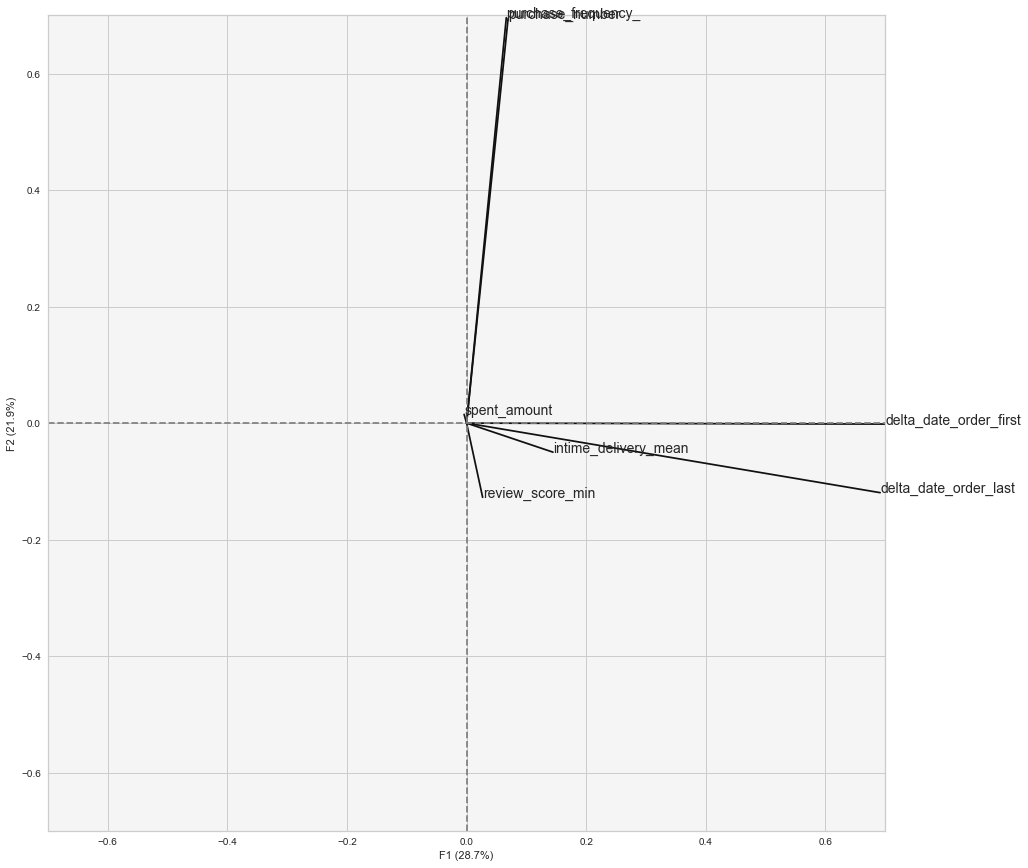

In [370]:
fig = plt.figure(figsize=(15,15))
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, X.columns[i], fontsize='14')

    
ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(0+1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(1+1, round(100*pca.explained_variance_ratio_[1],1)))

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

(-0.7, 0.7)

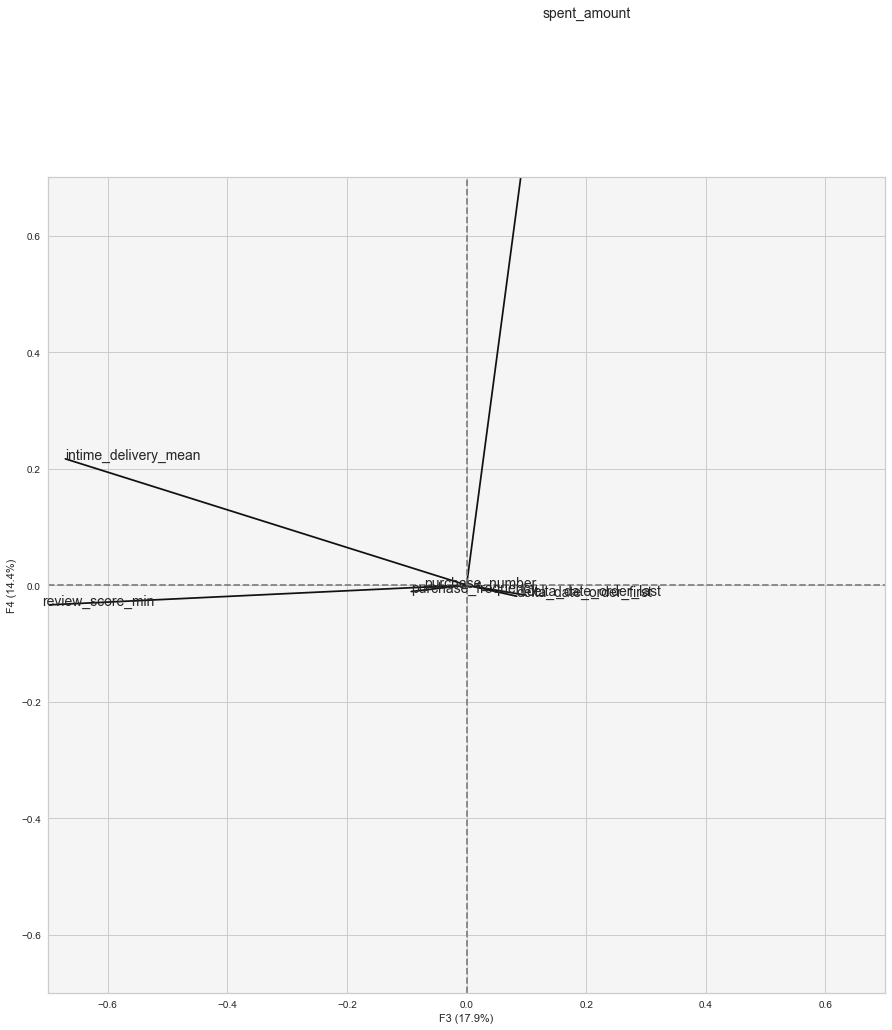

In [371]:
fig = plt.figure(figsize=(15,15))
for i, (x, y) in enumerate(zip(pcs[2, :], pcs[3, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, X.columns[i], fontsize='14')

ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(2+1, round(100*pca.explained_variance_ratio_[2],1)))
plt.ylabel('F{} ({}%)'.format(3+1, round(100*pca.explained_variance_ratio_[3],1)))

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

# Grille de recherche de meilleurs paramètres pour kmeans <a class="anchor" id="grille_kmeans"></a>

In [31]:
#StandardScaler(), PCA(n_components=n)

df_res_kmeans = pd.DataFrame(columns=['n_components', 'n_clusters', 'inertia', 'silhouette_score', 'davies_bouldin_score'])


for n in range(2,8):
    for k in range(3,10):
        pca = PCA(n_components=n)
        kmeans = KMeans(n_clusters=k, max_iter=1000)
        estimator = make_pipeline(StandardScaler(), pca, kmeans).fit(X_50perc_sample)
        labels_k = kmeans.labels_
        #print(data["clusters"])
        inert = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center = SSE
        db_score = davies_bouldin_score(X_50perc_sample, labels_k)
        silh_score = metrics.silhouette_score(X_50perc_sample, labels_k, metric='euclidean')
        df_res_kmeans = df_res_kmeans.append({'n_components':n, 'n_clusters':k, 'inertia':inert, 'silhouette_score':silh_score,
                                          'davies_bouldin_score':db_score}, ignore_index=True)
df_res_kmeans = df_res_kmeans.set_index('n_clusters')



In [32]:
df_res_kmeans

n_components        inertia  silhouette_score  \
n_clusters                                                  
3.0                  2.0   48880.479021          0.251315   
4.0                  2.0   33650.045027          0.277382   
5.0                  2.0   22309.329429          0.273053   
6.0                  2.0   17901.569298          0.198303   
7.0                  2.0   14728.149378          0.165854   
8.0                  2.0   11746.475060          0.165745   
9.0                  2.0   10462.145396          0.146627   
3.0                  3.0  106936.340727          0.251443   
4.0                  3.0   76194.937512          0.226073   
5.0                  3.0   62548.495839          0.222221   
6.0                  3.0   51582.206203          0.209377   
7.0                  3.0   46177.564564          0.152636   
8.0                  3.0   41020.985048          0.119095   
9.0                  3.0   37586.363947          0.068236   
3.0                  4.0  153850.855437          0.251261   
4.0                  4.0  123099.603530          0.225006   
5.0                  4.0   99555.708462          0.228174   
6.0                  4.0   85897.305344          0.222109   
7.0                  4.0   74932.305394          0.209572   
8.0                  4.0   65554.260365          0.227403   
9.0                  4.0   60093.050016          0.169166   
3.0                  5.0  186970.284692          0.251783   
4.0                  5.0  153244.129496          0.217657   
5.0                  5.0  128931.073924          0.221164   
6.0                  5.0  115175.461704          0.216054   
7.0                  5.0  104337.067217          0.202580   
8.0                  5.0   94784.441836          0.219514   
9.0                  5.0   87976.763980          0.071504   
3.0                  6.0  208983.563615          0.261252   
4.0                  6.0  175144.048622          0.217134   
5.0                  6.0  154408.212941          0.188939   
6.0                  6.0  133499.522970          0.194733   
7.0                  6.0  116540.635476          0.203882   
8.0                  6.0  107401.627175          0.163955   
9.0                  6.0   97927.193323          0.181461   
3.0                  7.0  210176.632530          0.238872   
4.0                  7.0  175158.151052          0.217138   
5.0                  7.0  150845.217137          0.220651   
6.0                  7.0  130106.154488          0.192549   
7.0                  7.0  116552.804467          0.203942   
8.0                  7.0  107008.870238          0.220176   
9.0                  7.0   97939.192724          0.182214   

            davies_bouldin_score  
n_clusters                        
3.0                     2.010362  
4.0                     2.340219  
5.0                     3.389632  
6.0                     3.154286  
7.0                     3.286090  
8.0                     3.188017  
9.0                     3.980988  
3.0                     2.006333  
4.0                     2.731122  
5.0                     2.596329  
6.0                     4.646678  
7.0                     4.651400  
8.0                     4.593431  
9.0                     4.284112  
3.0                     2.005696  
4.0                     2.734390  
5.0                     2.218036  
6.0                     2.189941  
7.0                     3.885794  
8.0                     3.786979  
9.0                     5.014224  
3.0                     2.004562  
4.0                     2.806079  
5.0                     2.263547  
6.0                     2.315271  
7.0                     4.195529  
8.0                     3.880363  
9.0                     5.019036  
3.0                     1.926360  
4.0                     2.690392  
5.0                     3.749295  
6.0                     3.558166  
7.0                     4.099874  
8.0                     4.476943  
9.0                     4.477125  
3.0                     2.499409

In [25]:
def plot_score(df_score, x):
    fig = plt.figure(figsize=(14,7))
    fig.add_subplot(221)
    plt.plot(df_score['inertia'],'b-',label='Sum of squared error')
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.legend()
    ax1 = fig.add_subplot(222)
    ax2 = ax1.twinx()
    df_score.plot(ax=ax1, y='silhouette_score', color='r',label='Silhouette Score')
    df_score.plot(ax=ax2, y='davies_bouldin_score', color='g',label='Score de Davies Bouldin')
    plt.xlabel("Number of cluster")
#     plt.ylabel("Silhouette & Davies Bouldin Scores")
    ax1.set_ylabel('silhouette_score')
    ax2.set_ylabel('davies_bouldin_score')
    plt.legend()
#     fig.add_subplot(223)
    
    
    plt.axvline(x, color='k', linestyle='--')
    
#     plt.xlabel("Number of cluster")
#     plt.ylabel("Davies Bouldin score")
#     plt.legend()
    plt.show()

<AxesSubplot:xlabel='n_clusters', ylabel='n_components'>

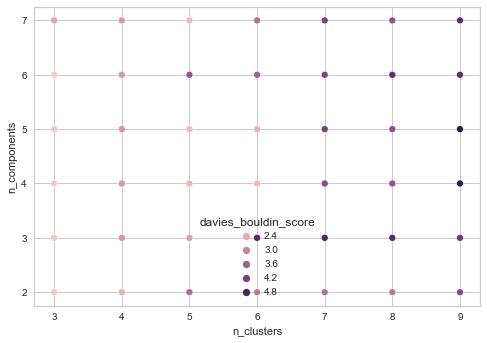

In [33]:
sns.scatterplot(data=df_res_kmeans, x="n_clusters", y="n_components", hue="davies_bouldin_score")

In [41]:
df_tmp = df_res_kmeans[df_res_kmeans['n_components'] == 2]

In [27]:
# min-max normalization:
# normalized_df=(df-df.min())/(df.max()-df.min())
# https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame

def _norm(df, col):
    return (df[col] - df[col].min()) / (df[col].max() - df[col].min())

n_components : 2


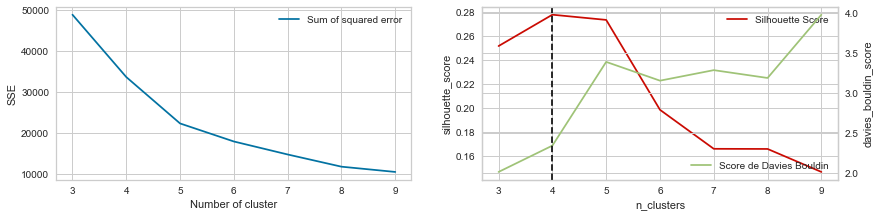

n_components : 3


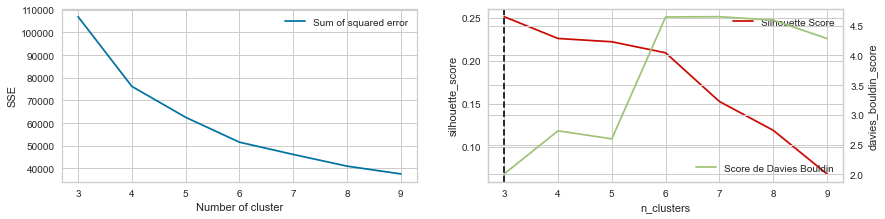

n_components : 4


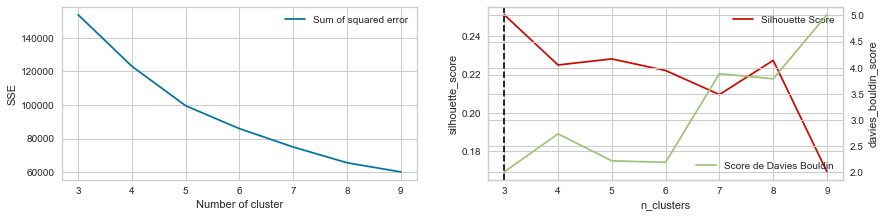

n_components : 5


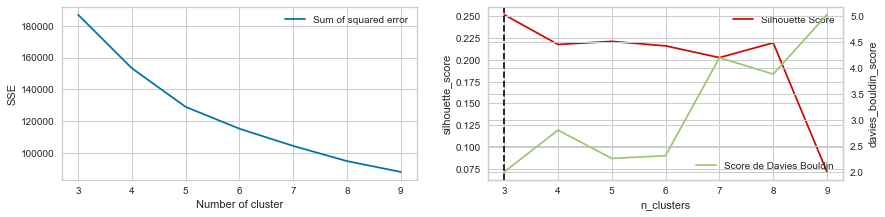

n_components : 6


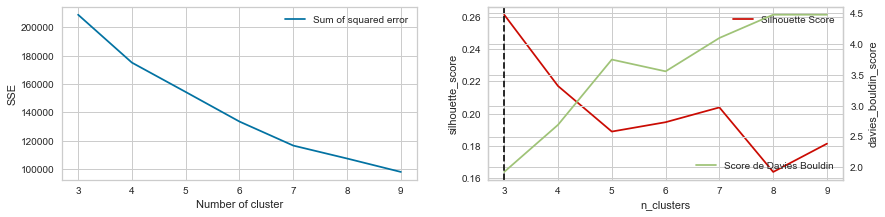

n_components : 7


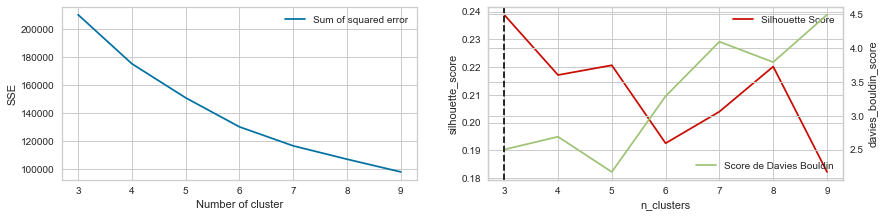

In [34]:
# affichage des résultats sur des graphiques
df_best_res = pd.DataFrame(columns=['n_components', 'max_norm'])

for n in range(2,8):
    mini_res = df_res_kmeans[df_res_kmeans['n_components'] == n].copy()
    max_silhoutte = mini_res['silhouette_score'].max()
    mini_res['sil_norm'] = _norm(mini_res, 'silhouette_score')
    mini_res['boul_norm'] = 1 - _norm(mini_res, 'davies_bouldin_score')
    mini_res['max'] = mini_res['sil_norm'] * 0.5 +  mini_res['boul_norm'] * 0.5
    best_score = mini_res['max'].max()
    
    df_best_res = df_best_res.append({'n_components':n, 'max_norm':best_score}, ignore_index=True)
#     print('max de score de silhouette est', max_silhoutte, 'lorsque le nombre de clusters est à ', 
#           mini_res[mini_res['silhouette_score'] == max_silhoutte].index)
#     min_bouldin = mini_res['davies_bouldin_score'].min()
#     print('min de score de davies bouldin est', min_bouldin, 'lorsque le nombre de clusters est à ', 
#           mini_res[mini_res['davies_bouldin_score'] == min_bouldin].index)
    print('n_components :', n)
    plot_score(mini_res, mini_res[mini_res['max'] == best_score].index)

In [35]:
df_best_res.style.highlight_max(subset=['max_norm'], color='#6EA4EC')

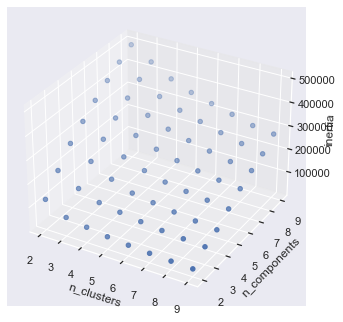

In [23]:
# interactive 3D visualization: https://stackabuse.com/seaborn-scatter-plot-tutorial-and-examples/

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df_res_kmeans.index
y = df_res_kmeans['n_components']
z = df_res_kmeans['inertia']

ax.set_xlabel("n_clusters")
ax.set_ylabel("n_components")
ax.set_zlabel("inertia")

ax.scatter(x, y, z)

plt.show()

## K-means avec les meilleurs paramètres <a class="anchor" id="kmeans_best"></a>

In [269]:
# PCA à 3 composants + kmeans avec k=3
pca_best = PCA(n_components=3)
kmeans_best = KMeans(n_clusters=3, max_iter=1000)
estimator_best = make_pipeline(StandardScaler(), pca_best, kmeans_best).fit(X_50perc_sample)
labels_kbest = kmeans_best.labels_
#print(data["clusters"])
inert_best = kmeans_best.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
db_score_best = davies_bouldin_score(X_50perc_sample, labels_kbest)
silh_score_best = metrics.silhouette_score(X_50perc_sample, labels_kbest, metric='euclidean')

In [37]:
print('Inertia :', inert_best, ' Davies Bouldin score : ', db_score_best, ' Silhouette score : ', silh_score_best)

Inertia : 106935.3381434052  Davies Bouldin score :  2.0050012430032518  Silhouette score :  0.25118701087273226


For n_clusters = 3 The average silhouette_score is : 0.5623075654650223


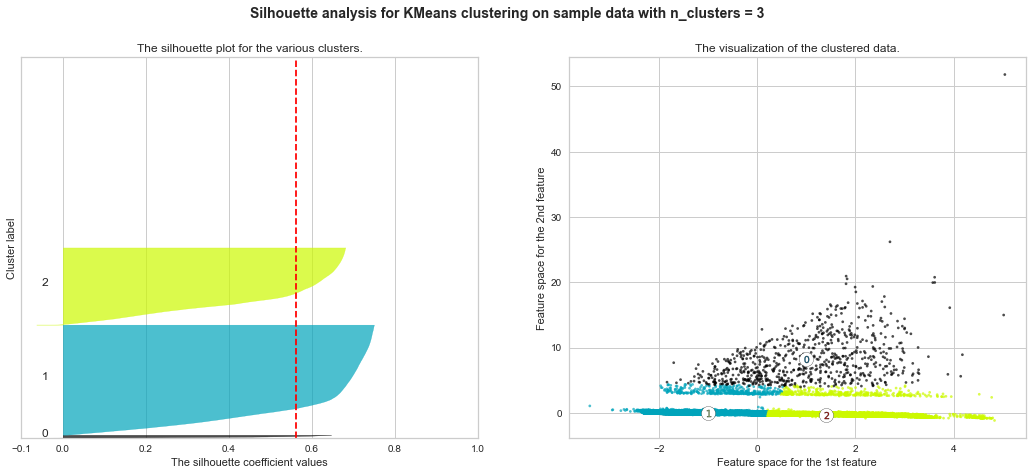

In [270]:
n_clusters = 3

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (3 + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
reduced_data = PCA(n_components=2).fit_transform(X_50perc_sample_scaled)


# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(reduced_data, labels_kbest)
print("For n_clusters =", 3,
      "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(reduced_data, labels_kbest)

y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels_kbest == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(labels_kbest.astype(float) / n_clusters)
ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = kmeans_best.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = 3"),
             fontsize=14, fontweight='bold')

plt.show()

## Visualisation de 3 clusters kmeans obtenus <a class="anchor" id="kmeans_best_viz"></a>

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

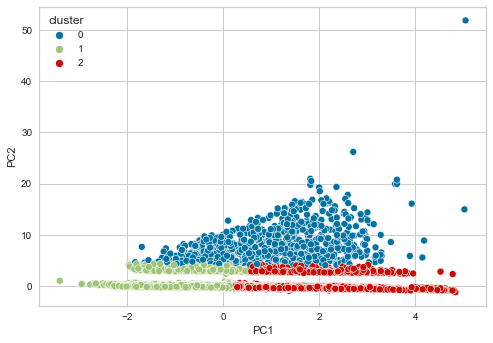

In [271]:
pca_X_50perc = pd.DataFrame(PCA(n_components=2).fit_transform(X_50perc_sample_scaled),columns=['PC1','PC2'])
pca_X_50perc['cluster'] = pd.Categorical(labels_kbest)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_X_50perc)

<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

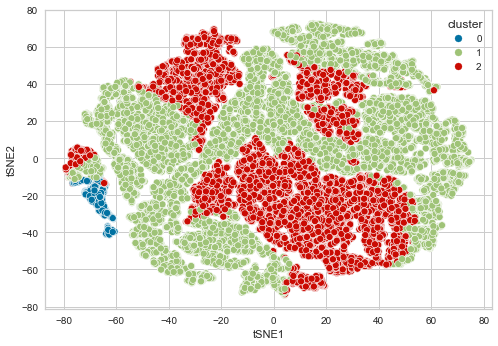

In [272]:
# affichage tSNE
tsne_affichage = TSNE(n_components=2)
X50perc_tsne = pd.DataFrame(tsne_affichage.fit_transform(X_50perc_sample_scaled),columns=['tSNE1','tSNE2'])
X50perc_tsne['cluster'] = pd.Categorical(labels_kbest)
sns.scatterplot(x="tSNE1",y="tSNE2",hue="cluster",data=X50perc_tsne)

## Analyse des 3 clusters kmeans obtenus <a class="anchor" id="kmeans_best_analysis"></a>

In [41]:
X50perc_clustered = X_50perc_sample.copy()
X50perc_clustered['cluster'] = pd.Categorical(labels_kbest)

<Figure size 576x396 with 0 Axes>

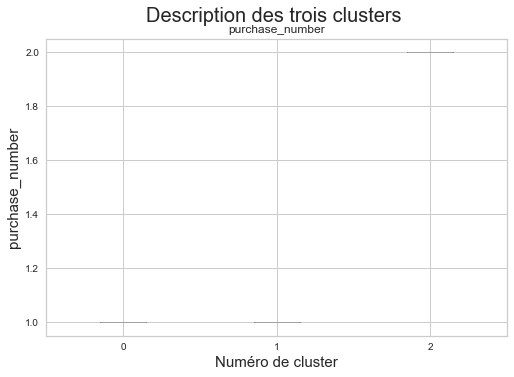

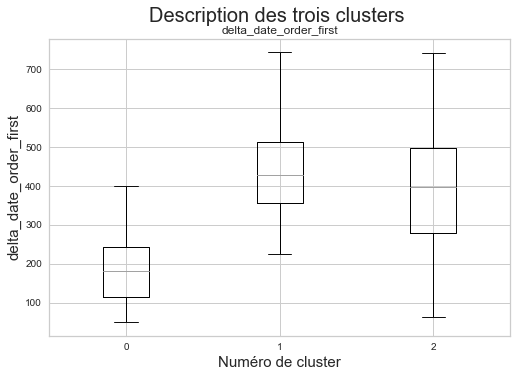

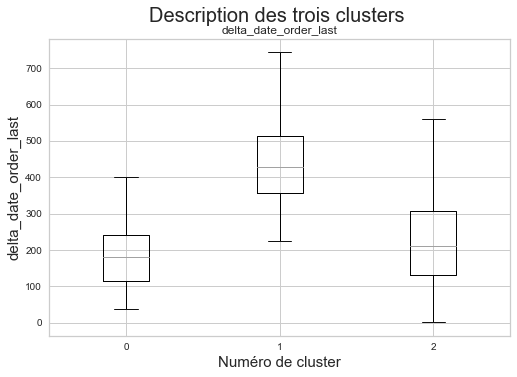

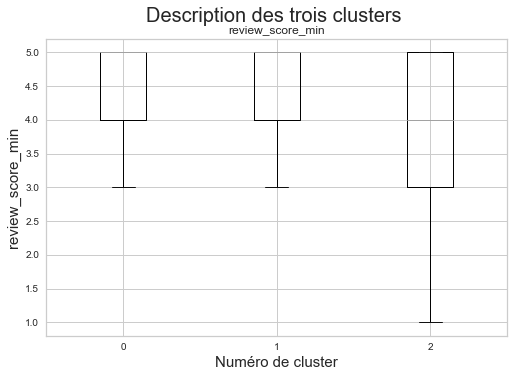

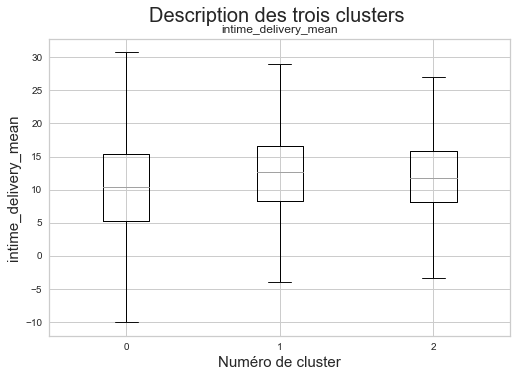

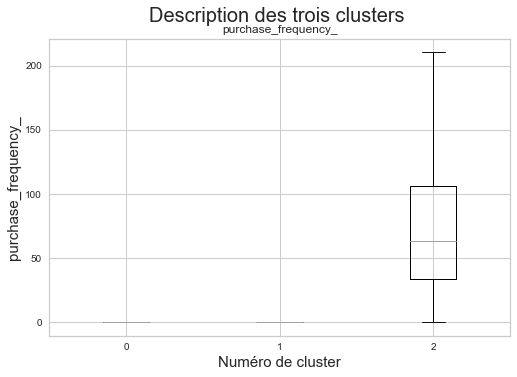

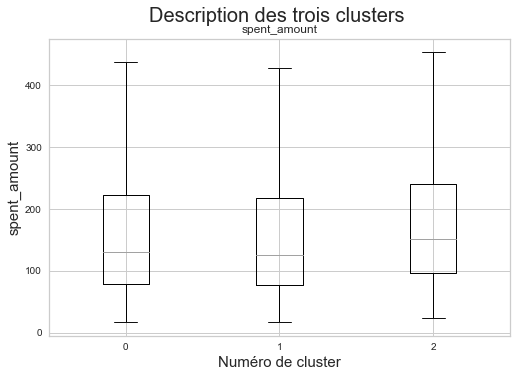

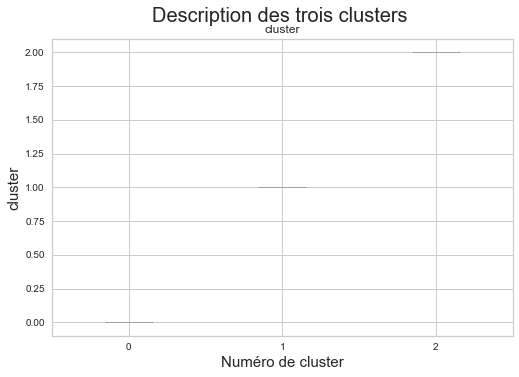

In [42]:
plt.figure()

for col in X50perc_clustered.columns:
    X50perc_clustered.boxplot(column=[col], by= X50perc_clustered['cluster'], showfliers=False)
# plt.title('AAA')
    plt.suptitle('Description des trois clusters ', fontsize = 20) # 
    plt.xlabel('Numéro de cluster', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel(f'{col}', fontsize = 15) # y-axis label with fontsize 15
    plt.show()

In [53]:
X50perc_clustered[X50perc_clustered['cluster'] == 2]['purchase_frequency_'].mean()

77.7737510048544

In [92]:
# attribution de noms aux clusters
X50perc_tsne['cluster']

0        0
1        0
2        0
3        2
4        0
        ..
46666    0
46667    2
46668    0
46669    1
46670    0
Name: cluster, Length: 46671, dtype: category
Categories (3, int64): [0, 1, 2]

In [274]:
X50perc_tsne['cluster_name'] = np.where((X50perc_tsne['cluster'] == 0),'nouveau_client', X50perc_tsne['cluster'])

In [275]:
# X50perc_tsne['cluster_name'] = np.where((X50perc_tsne['cluster'] == 1),'client_mécontant', X50perc_tsne['cluster_name'])
X50perc_tsne['cluster_name'] = np.where((X50perc_tsne['cluster'] == 1),'client_dormant', X50perc_tsne['cluster_name'])

In [276]:
#  X50perc_tsne['cluster_name'] = np.where((X50perc_tsne['cluster'] == 2),'client_dormant', X50perc_tsne['cluster_name'])
X50perc_tsne['cluster_name'] = np.where((X50perc_tsne['cluster'] == 2),'bon_client', X50perc_tsne['cluster_name'])

In [277]:
X50perc_tsne['cluster_name']

0        client_dormant
1        client_dormant
2        client_dormant
3            bon_client
4        client_dormant
              ...      
46666    client_dormant
46667        bon_client
46668    client_dormant
46669    client_dormant
46670    client_dormant
Name: cluster_name, Length: 46671, dtype: object

In [47]:
X50perc_tsne['cluster']

0        0
1        0
2        0
3        1
4        0
        ..
46666    0
46667    1
46668    0
46669    0
46670    0
Name: cluster, Length: 46671, dtype: category
Categories (3, int64): [0, 1, 2]

<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

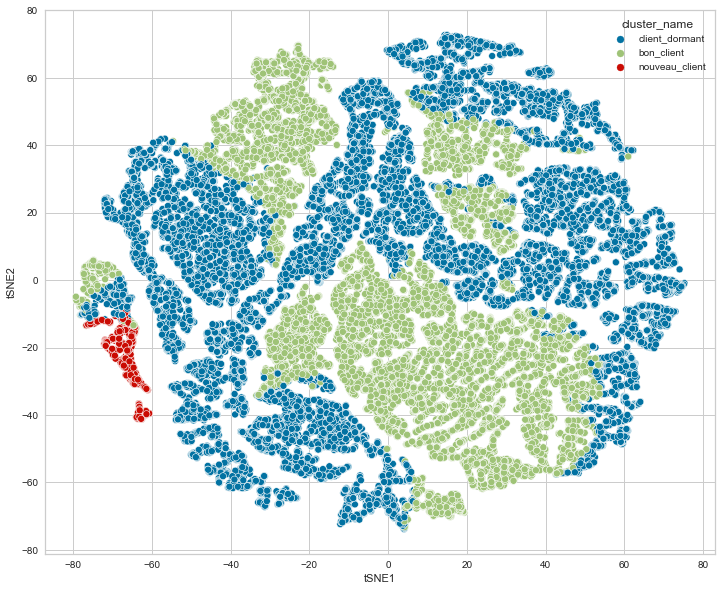

In [278]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x="tSNE1",y="tSNE2",hue="cluster_name",data=X50perc_tsne)

In [56]:
# df_description_3clskmeans = pd.read_excel('C:/Users/piari/Documents/Projet4_ecommerce/Description_3clusters_kmeans.xlsx')
#  3clusters_kmeans_rfm
df_description_3clskmeans = pd.read_excel('C:/Users/piari/Documents/Projet4_ecommerce/3clusters_kmeans_rfm.xlsx')

In [57]:
df_description_3clskmeans

Charactéristique  nouveau_client             client_dormant  \
0             Récence  nouveau client  ancient client, "dormant"   
1  Fréquence d'achats               0                          0   
2            Montant          moyenne                    moyenne   
3       Nombre_achats               1                          1   
4           Livraison              ok                         ok   
5        Satisfaction    très contant               très content   

            bon_client  
0  vieux, achat récent  
1                   77  
2                élevé  
3                    2  
4                   ok  
5              contant

In [58]:
X.columns

Index(['purchase_number', 'delta_date_order_first', 'delta_date_order_last',
       'review_score_min', 'intime_delivery_mean', 'purchase_frequency_',
       'spent_amount'],
      dtype='object')

## Tests PCA à 4 composants + kmeans à k=5

In [280]:
# RobustScaler, QuantileTransformer
pca4 = PCA(n_components=4)
kmeans5 = KMeans(n_clusters=5, max_iter=1000)
estimator_pca4k5 = make_pipeline(StandardScaler(), pca4, kmeans5).fit(X_50perc_sample)
labels_pca4k5 = kmeans5.labels_
#print(data["clusters"])
inert_pca4k5 = kmeans5.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
db_score_pca4k5 = davies_bouldin_score(X_50perc_sample, labels_pca4k5)
silh_score_pca4k5 = metrics.silhouette_score(X_50perc_sample, labels_pca4k5, metric='euclidean')

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

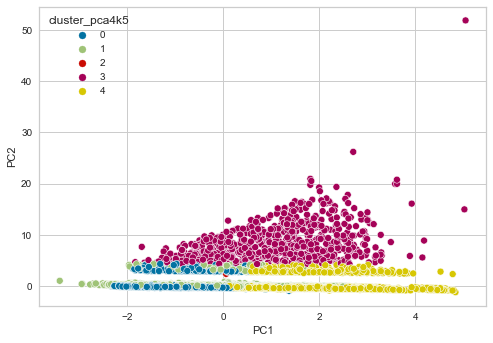

In [282]:
pca_X_50perc['cluster_pca4k5'] = pd.Categorical(labels_pca4k5)
sns.scatterplot(x="PC1",y="PC2",hue="cluster_pca4k5",data=pca_X_50perc)

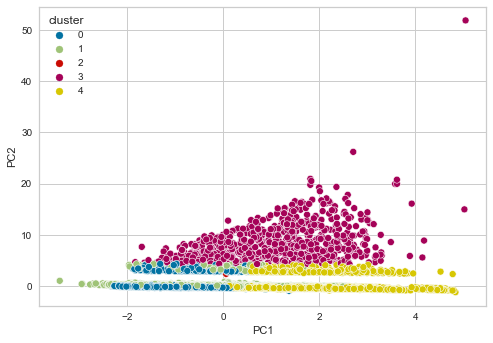

<AxesSubplot:xlabel='PC3', ylabel='PC4'>

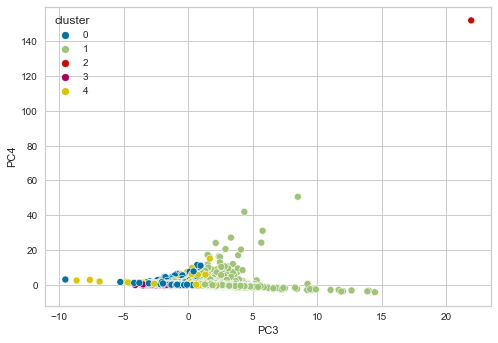

In [283]:
pca_X_50perc_pca4 = pd.DataFrame(PCA(n_components=4).fit_transform(X_50perc_sample_scaled),columns=['PC1','PC2','PC3','PC4'])
pca_X_50perc_pca4['cluster'] = pd.Categorical(labels_pca4k5)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_X_50perc_pca4)
plt.show()
sns.scatterplot(x="PC3",y="PC4",hue="cluster",data=pca_X_50perc_pca4)


# Classification ascendante hiérarchique (CAH) <a class="anchor" id="cah"></a>

In [59]:
kmeans_preproc = KMeans(n_clusters=1000, max_iter=1000)
estimator_preproc = make_pipeline(StandardScaler(), kmeans_preproc).fit(X)
cluster_centers1000 = kmeans_preproc.cluster_centers_

In [62]:
cluster_centers1000

array([[-1.64245411e-01,  1.55028571e+00,  1.57411339e+00, ...,
        -8.05525978e-01, -1.08180215e-01, -1.94519907e-01],
       [-1.64245411e-01, -8.85500694e-02, -7.05061308e-02, ...,
         1.86218329e-01, -1.08180215e-01,  1.09469405e-03],
       [-1.64245411e-01,  2.43631511e-01,  2.62847779e-01, ...,
         1.17559337e+00, -1.08180215e-01, -8.00344697e-02],
       ...,
       [ 4.44658021e+00,  9.82621839e-01, -3.28961465e-01, ...,
         9.55385466e-02,  8.24084493e+00, -8.19096809e-02],
       [-1.64245411e-01,  2.72829941e-01,  2.92149255e-01, ...,
         2.23949207e-01, -1.08180215e-01,  2.49157058e-01],
       [-1.64245411e-01,  1.51690008e+00,  1.54060994e+00, ...,
         1.32903548e+00, -1.08180215e-01,  6.25218933e-01]])

In [63]:
clustering_hca = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
estimator_hca = make_pipeline(StandardScaler(), clustering_hca).fit(cluster_centers1000)

In [60]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

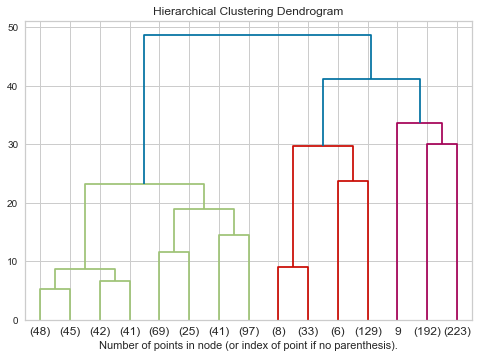

In [65]:
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(estimator_hca[1], truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [66]:
estimator_hca[1].n_clusters_

1000

In [129]:
sklearn.__version__

'0.23.2'

In [136]:
!pip install --upgrade --user scikit-learn

  Using cached scikit_learn-0.24.2-cp38-cp38-win_amd64.whl (6.9 MB)


In [131]:
pip install -U scikit-learn

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Accès refusé: 'c:\\programdata\\anaconda3\\lib\\site-packages\\scikit_learn-0.23.2.dist-info\\COPYING'
Consider using the `--user` option or check the permissions.



In [132]:
conda install -c conda-forge scikit-learn 

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
Note: you may need to restart the kernel to use updated packages.





==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: C:\ProgramData\Anaconda3




    conda-4.10.1               |   py38haa244fe_0         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/win-64::python_abi-3.8-1_cp38

The following packages will be UPDATED:

  conda               pkgs/main::conda-4.9.2-py38haa95532_0 --> conda-forge::conda-4.10.1-py38haa244fe_0




conda-4.10.1         | 3.1 MB    |            |   0% 
conda-4.10.1         | 3.1 MB    |            |   1% 
conda-4.10.1         | 3.1 MB    | ########## | 100% 
conda-4.10.1         | 3.1 MB    | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... failed


In [139]:
# clustering = AgglomerativeClustering().fit(X)

df_res_clustering_hca = pd.DataFrame(columns=['n_clusters', 'silhouette_score', 'davies_bouldin_score'])
# pca2 = PCA(n_components=2)

for k in range(2, 10):
    clustering_hca = AgglomerativeClustering(n_clusters=k)
    estimator_hca_k = clustering_hca.fit(cluster_centers1000)
    labels_k = clustering_hca.labels_
    #print(data["clusters"])
#     dist = clustering_hca.distances_ # 
    labels_forX = pd.Series([clustering_hca.labels_[idx] for idx in kmeans_preproc.labels_])
    db_score = davies_bouldin_score(X, labels_forX)
    silh_score = metrics.silhouette_score(X, labels_forX, metric='euclidean')
    df_res_clustering_hca = df_res_clustering_hca.append({'n_clusters':k, 'silhouette_score':silh_score,
                                          'davies_bouldin_score':db_score}, ignore_index=True)
    
df_res_clustering_hca = df_res_clustering_hca.set_index('n_clusters')

In [226]:
kmeans_preproc.labels_

array([854, 119, 219, ..., 403, 145, 175])

In [140]:
df_res_clustering_hca

silhouette_score  davies_bouldin_score
n_clusters                                        
2.0                 0.996269              0.002600
3.0                 0.967885              0.338056
4.0                 0.061344              3.334303
5.0                 0.046447              3.822793
6.0                 0.046513              3.227523
7.0                 0.044835              2.888469
8.0                 0.032549              2.847260
9.0                -0.010185              3.379747

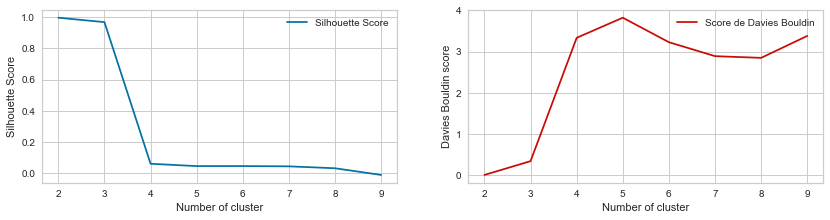

In [141]:
fig = plt.figure(figsize=(14,7))
fig.add_subplot(221)
plt.plot(df_res_clustering_hca['silhouette_score'],'b-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
fig.add_subplot(222)
plt.plot(df_res_clustering_hca['davies_bouldin_score'],'r-',label='Score de Davies Bouldin')
plt.xlabel("Number of cluster")
plt.ylabel("Davies Bouldin score")
plt.legend()

plt.show()

In [68]:
X_clusterhca = X.copy()

In [69]:
# X_clusterhca['labels_hca'] = pd.Series([clustering_hca.labels_[idx] for idx in kmeans_preproc.labels_])


In [70]:
X_clusterhca

purchase_number  delta_date_order_first  delta_date_order_last  \
0                    1              160.273507             160.273507   
1                    1              163.263090             163.263090   
2                    1              585.850868             585.850868   
3                    1              369.875428             369.875428   
4                    1              336.905972             336.905972   
...                ...                     ...                    ...   
93337                1              495.853958             495.853958   
93338                1              310.890532             310.890532   
93339                1              617.070162             617.070162   
93340                1              168.092095             168.092095   
93341                1              532.883021             532.883021   

       review_score_min  intime_delivery_mean  purchase_frequency_  \
0                     5              4.132905                  0.0   
1                     4              4.248125                  0.0   
2                     3              1.389734                  0.0   
3                     4             11.108970                  0.0   
4                     5              7.035463                  0.0   
...                 ...                   ...                  ...   
93337                 5             26.609722                  0.0   
93338                 4              2.063657                  0.0   
93339                 5             29.468704                  0.0   
93340                 5             13.503866                  0.0   
93341                 5             15.601528                  0.0   

       spent_amount  labels_hca  
0            153.90           1  
1             35.48           1  
2            103.44           1  
3             61.25           1  
4            213.78           1  
...             ...         ...  
93337       4393.12           1  
93338        104.27           1  
93339        135.02           1  
93340        152.38           1  
93341         86.13           1  

[93342 rows x 8 columns]

In [284]:
X_clusterhca_scaled = X_scaled.copy()

## Clustering HCA en 3 clusters

In [99]:
clustering_hca3 = AgglomerativeClustering(n_clusters=3)
estimator_hca3 = clustering_hca3.fit_predict(cluster_centers1000)

In [76]:
labels_hca3 = clustering_hca3.labels_

In [77]:
X_clusterhca['labels_hca3'] = pd.Series([clustering_hca3.labels_[idx] for idx in kmeans_preproc.labels_])

In [78]:
len(labels_hca3)

1000

In [81]:
X_clusterhca['labels_hca'].unique()

array([1, 3, 4, 0, 8, 2, 7, 5, 6], dtype=int64)

In [82]:
len(cluster_centers1000[0])

7

In [83]:
X_clusterhca.drop(['labels_hca'], axis=1, inplace = True)

In [85]:
X_clusterhca['labels_hca3'].unique()

array([0, 2, 1], dtype=int64)

## Visualisation de 3 clusters HCA obtenus <a class="anchor" id="hca3_best_viz"></a>

In [92]:
len(pca_X.index)

93342

In [93]:
len(X_clusterhca.index)

93342

In [285]:
pca_X = pd.DataFrame(PCA(n_components=2).fit_transform(X_scaled),columns=['PC1','PC2'])
pca_X['labels_hca3'] = X_clusterhca['labels_hca3']
# sns.scatterplot(x="PC1",y="PC2",hue="labels_hca3",data=X)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

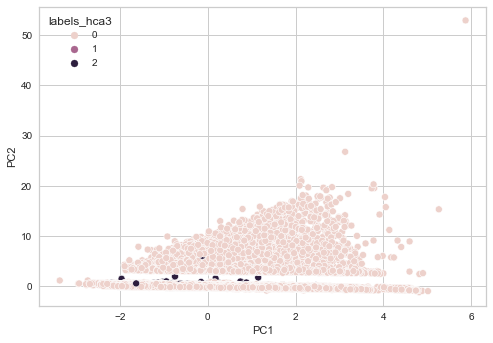

In [286]:
sns.scatterplot(x="PC1",y="PC2",hue="labels_hca3",data=pca_X)

<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

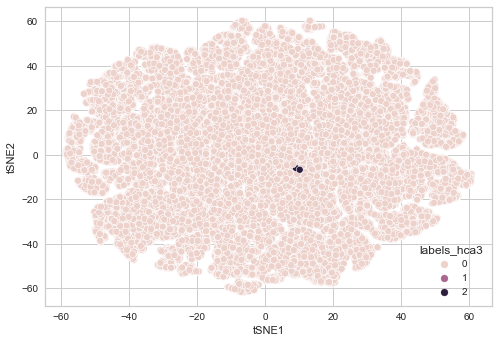

In [287]:
# affichage tSNE
tsne_affichage_hca = TSNE(n_components=2)
X_tsne = pd.DataFrame(tsne_affichage_hca.fit_transform(X_scaled),columns=['tSNE1','tSNE2'])
X_tsne['labels_hca3'] = X_clusterhca['labels_hca3']
sns.scatterplot(x="tSNE1",y="tSNE2",hue="labels_hca3",data=X_tsne)

## Clustering HCA en 4 clusters

In [288]:
clustering_hca4 = AgglomerativeClustering(n_clusters=4)
estimator_hca4 = clustering_hca4.fit_predict(cluster_centers1000)
labels_hca4 = clustering_hca4.labels_

In [289]:
X_clusterhca['labels_hca4'] = pd.Series([clustering_hca4.labels_[idx] for idx in kmeans_preproc.labels_])

In [290]:
X_clusterhca4 = X_clusterhca.drop(['labels_hca3'], axis=1).copy()

## Visualisation de 4 clusters HCA obtenus <a class="anchor" id="hca4_best_viz"></a>

In [291]:
pca_X['labels_hca4'] = X_clusterhca4['labels_hca4']

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

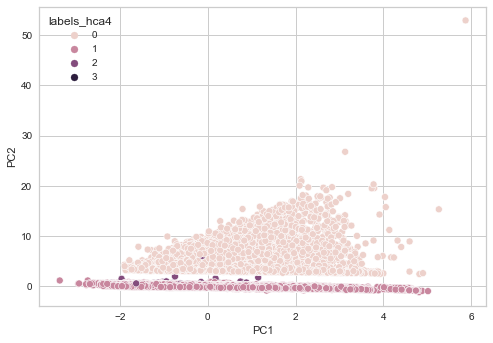

In [292]:
sns.scatterplot(x="PC1",y="PC2",hue="labels_hca4",data=pca_X)

<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

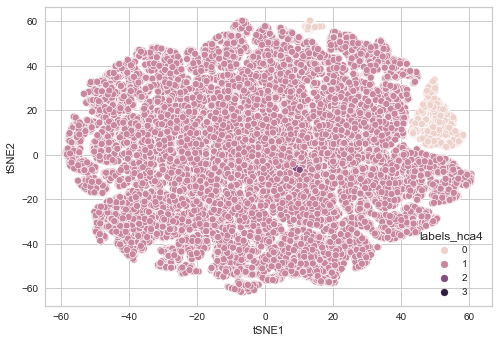

In [301]:
# affichage tSNE
X_tsne['labels_hca4'] = X_clusterhca4['labels_hca4']
sns.scatterplot(x="tSNE1",y="tSNE2",hue="labels_hca4",data=X_tsne)

## Analyse des 4 clusters obtenus <a class="anchor" id="hca4_analysis"></a>

In [109]:
X_clusterhca4[X_clusterhca4['labels_hca4'] == 3]

purchase_number  delta_date_order_first  delta_date_order_last  \
3723                1              383.087106             383.087106   

      review_score_min  intime_delivery_mean  purchase_frequency_  \
3723                 1              5.234387                  0.0   

      spent_amount  labels_hca4  
3723     109340.65            3

<Figure size 576x396 with 0 Axes>

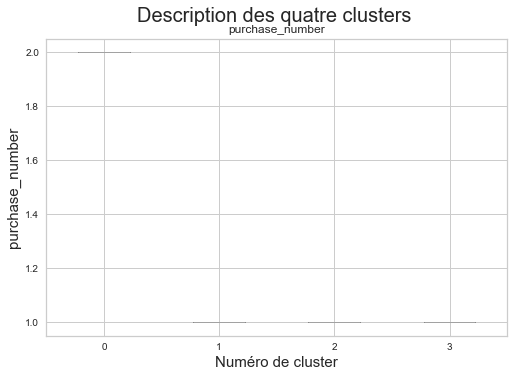

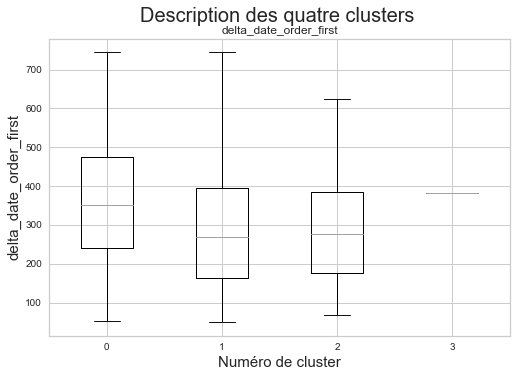

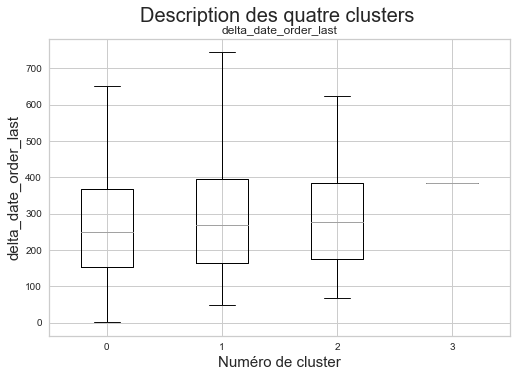

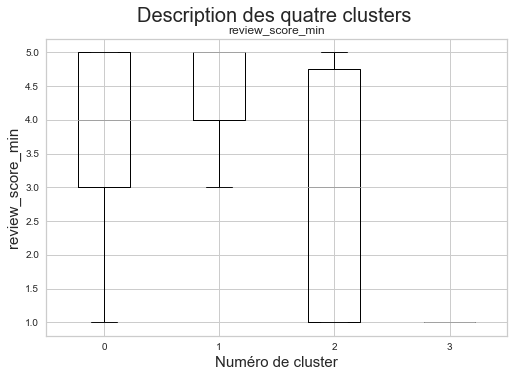

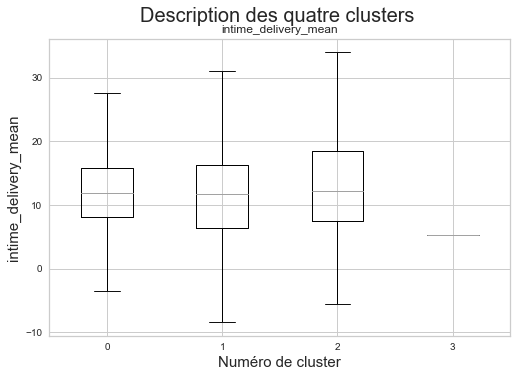

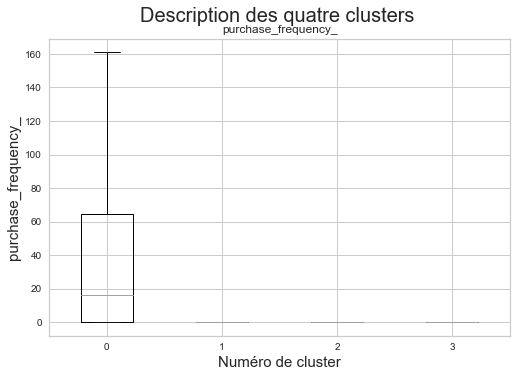

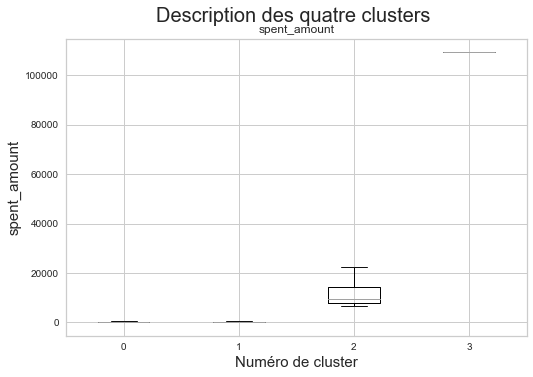

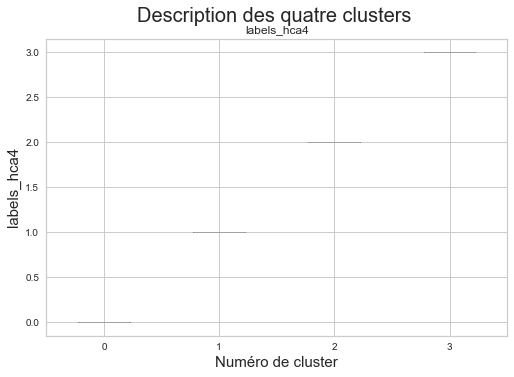

In [108]:
plt.figure()

for col in X_clusterhca4.columns:
    X_clusterhca4.boxplot(column=[col], by= X_clusterhca4['labels_hca4'], showfliers=False)
# plt.title('AAA')
    plt.suptitle('Description des quatre clusters ', fontsize = 20) # 
    plt.xlabel('Numéro de cluster', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel(f'{col}', fontsize = 15) # y-axis label with fontsize 15
    plt.show()

In [294]:
X_clusterhca4['cluster_name'] = np.where((X_clusterhca4['labels_hca4'] == 0),'client_frequent', X_clusterhca4['labels_hca4'])

In [295]:
X_clusterhca4['cluster_name'] = np.where((X_clusterhca4['labels_hca4'] == 1),'client_content', X_clusterhca4['cluster_name'])

In [296]:
X_clusterhca4['cluster_name'] = np.where((X_clusterhca4['labels_hca4'] == 2),'client_genereux', X_clusterhca4['cluster_name'])

In [297]:
X_clusterhca4['cluster_name'] = np.where((X_clusterhca4['labels_hca4'] == 3),'client_mecontant', X_clusterhca4['cluster_name'])

In [298]:
X_clusterhca4['cluster_name'].unique()

array(['client_content', 'client_frequent', 'client_genereux',
       'client_mecontant'], dtype=object)

In [299]:
X_tsne['cluster_name'] = X_clusterhca4['cluster_name']

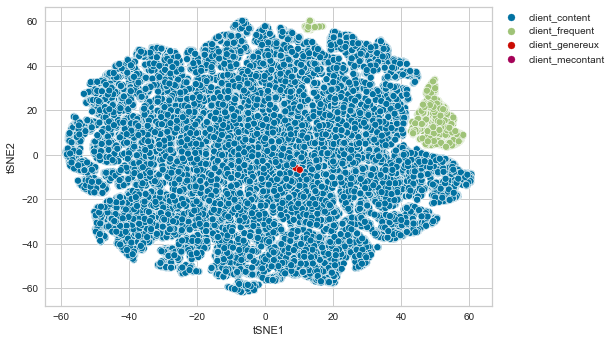

In [300]:
sns.scatterplot(x="tSNE1",y="tSNE2",hue="cluster_name",data=X_tsne)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.01), frameon=False)

# DBSCAN clustering algorithm <a class="anchor" id="dbscan"></a>

## Density-Based Spatial Clustering of Applications with Noise

In [146]:
# A random 10% sample of the DataFrame
# df.sample(frac=0.5, replace=True, random_state=1)
X_10perc_sample = X.sample(frac=0.1, random_state=1)

In [147]:
X_10perc_sample

purchase_number  delta_date_order_first  delta_date_order_last  \
55876                1              160.205162             160.205162   
86488                1              254.724086             254.724086   
78366                1               64.033345              64.033345   
41490                1              320.868669             320.868669   
44306                1               67.164213              67.164213   
...                ...                     ...                    ...   
17340                1              562.005671             562.005671   
77606                1              156.060868             156.060868   
4884                 1              110.112755             110.112755   
47596                1              482.898160             482.898160   
72712                1              379.169410             379.169410   

       review_score_min  intime_delivery_mean  purchase_frequency_  \
55876                 5             15.997940                  0.0   
86488                 5             21.099618                  0.0   
78366                 5              6.997164                  0.0   
41490                 5             21.130567                  0.0   
44306                 3              3.962569                  0.0   
...                 ...                   ...                  ...   
17340                 5             14.472257                  0.0   
77606                 5             11.274606                  0.0   
4884                  5             19.056389                  0.0   
47596                 5              4.357928                  0.0   
72712                 4             33.980764                  0.0   

       spent_amount  
55876        179.38  
86488         58.74  
78366        152.08  
41490        267.80  
44306        103.80  
...             ...  
17340         64.28  
77606        115.34  
4884          75.49  
47596        345.40  
72712        116.97  

[9334 rows x 7 columns]

In [302]:
X_10perc_sample_scaled = std_scale.transform(X_10perc_sample)

If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998) 
https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd


In [303]:
neighbors = NearestNeighbors(n_neighbors=14)
neighbors_fit = neighbors.fit(X_10perc_sample_scaled)
distances, indices = neighbors_fit.kneighbors(X_10perc_sample_scaled)

In [304]:
distances

array([[0.        , 0.02466968, 0.08462272, ..., 0.15310682, 0.15738955,
        0.16113838],
       [0.        , 0.05293692, 0.06413222, ..., 0.16416124, 0.17008653,
        0.18368303],
       [0.        , 0.01920838, 0.06733428, ..., 0.09692723, 0.09908905,
        0.10441227],
       ...,
       [0.        , 0.05693708, 0.06591374, ..., 0.11180116, 0.11485506,
        0.11605029],
       [0.        , 0.25407105, 0.27443452, ..., 0.3802109 , 0.38949476,
        0.3944015 ],
       [0.        , 0.48309194, 0.7147605 , ..., 0.9257054 , 0.93361238,
        0.95811102]])

In [305]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [306]:
distances

array([1.95450071e-03, 1.95450071e-03, 2.35197366e-03, ...,
       6.47762875e+00, 6.49039020e+00, 1.62426346e+01])

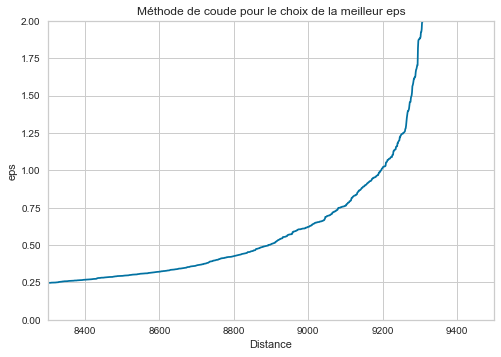

In [309]:
# plot
plt.plot(distances)
# plt.xlim([8300, 9500])
# plt.ylim([45, 300])
plt.xlim([8300, 9500])
plt.ylim([0, 2])
plt.xlabel('Distance')
plt.ylabel('eps')
plt.title('Méthode de coude pour le choix de la meilleur eps')
plt.show()

In [317]:
df_res_clustering_dbscan = pd.DataFrame(columns=['min_samples', 'eps', 'n_clusters', 'silhouette_score', 'davies_bouldin_score'])
# pca2 = PCA(n_components=2)
# eps > 23 crée que 1 cluster
# eps_X13 = [0.35, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5]
# min_samples_X13 = [21, 22, 23, 24, 25, 26, 27, 28]
eps = [0.25, 0.35, 0.45, 0.5, 0.6, 0.7, 0.75]
min_samples = [12, 13, 14, 15, 16, 17, 18, 19, 20]


for e in eps:
    for ms in min_samples:
        clustering_dbscan = DBSCAN(eps=e, min_samples=ms)
        estimator_dbscan = make_pipeline(StandardScaler(), clustering_dbscan).fit(X_10perc_sample)
        labels_dbscan = clustering_dbscan.labels_
        print('e=', e, 'ms=', ms)
#         k - le nombre de clusters
        k = pd.Series(labels_dbscan).nunique()
        labels_list = list(pd.Series(labels_dbscan).unique())
#         si il y a des clusters avec un label "-1", on ne les comptes pas
        labels_list.sort()
        k += labels_list[0]
#         print("nombre d'étiquettes : ", len(labels_k))
        # calcul des scores
        db_score = davies_bouldin_score(X_10perc_sample, labels_dbscan)
        silh_score = metrics.silhouette_score(X_10perc_sample, labels_dbscan, metric='euclidean')   
        df_res_clustering_dbscan = df_res_clustering_dbscan.append({'min_samples':ms,'eps':e, 'n_clusters':k,
                                                                    'silhouette_score':silh_score,
                                              'davies_bouldin_score':db_score}, ignore_index=True)
        
    
df_res_clustering_dbscan = df_res_clustering_dbscan.set_index('eps')

e= 0.25 ms= 12
e= 0.25 ms= 13
e= 0.25 ms= 14
e= 0.25 ms= 15
e= 0.25 ms= 16
e= 0.25 ms= 17
e= 0.25 ms= 18
e= 0.25 ms= 19
e= 0.25 ms= 20
e= 0.35 ms= 12
e= 0.35 ms= 13
e= 0.35 ms= 14
e= 0.35 ms= 15
e= 0.35 ms= 16
e= 0.35 ms= 17
e= 0.35 ms= 18
e= 0.35 ms= 19
e= 0.35 ms= 20
e= 0.45 ms= 12
e= 0.45 ms= 13
e= 0.45 ms= 14
e= 0.45 ms= 15
e= 0.45 ms= 16
e= 0.45 ms= 17
e= 0.45 ms= 18
e= 0.45 ms= 19
e= 0.45 ms= 20
e= 0.5 ms= 12
e= 0.5 ms= 13
e= 0.5 ms= 14
e= 0.5 ms= 15
e= 0.5 ms= 16
e= 0.5 ms= 17
e= 0.5 ms= 18
e= 0.5 ms= 19
e= 0.5 ms= 20
e= 0.6 ms= 12
e= 0.6 ms= 13
e= 0.6 ms= 14
e= 0.6 ms= 15
e= 0.6 ms= 16
e= 0.6 ms= 17
e= 0.6 ms= 18
e= 0.6 ms= 19
e= 0.6 ms= 20
e= 0.7 ms= 12
e= 0.7 ms= 13
e= 0.7 ms= 14
e= 0.7 ms= 15
e= 0.7 ms= 16
e= 0.7 ms= 17
e= 0.7 ms= 18
e= 0.7 ms= 19
e= 0.7 ms= 20
e= 0.75 ms= 12
e= 0.75 ms= 13
e= 0.75 ms= 14
e= 0.75 ms= 15
e= 0.75 ms= 16
e= 0.75 ms= 17
e= 0.75 ms= 18
e= 0.75 ms= 19
e= 0.75 ms= 20


In [217]:
list(pd.Series(labels_dbscan).unique())

[0, 1, -1, 2, 3, 4, 5]

In [318]:
df_res_clustering_dbscan[df_res_clustering_dbscan['n_clusters'] <= 2]

Empty DataFrame
Columns: [min_samples, n_clusters, silhouette_score, davies_bouldin_score]
Index: []

min_samples :  12
sil_norm eps
0.25    0.000000
0.35    0.332219
0.45    0.065659
0.50    0.018822
0.60    1.000000
0.70    0.223463
0.75    0.760814
Name: sil_norm, dtype: float64
boul_norm eps
0.25    1.000000
0.35    0.856351
0.45    0.762782
0.50    0.800830
0.60    0.387644
0.70    0.352361
0.75    0.000000
Name: boul_norm, dtype: float64
max eps
0.25    0.500000
0.35    0.594285
0.45    0.414220
0.50    0.409826
0.60    0.693822
0.70    0.287912
0.75    0.380407
Name: max, dtype: float64
best_score 0.6938222035910206
min_samples : 12
--------------------------
x :  Float64Index([0.6], dtype='float64', name='eps')


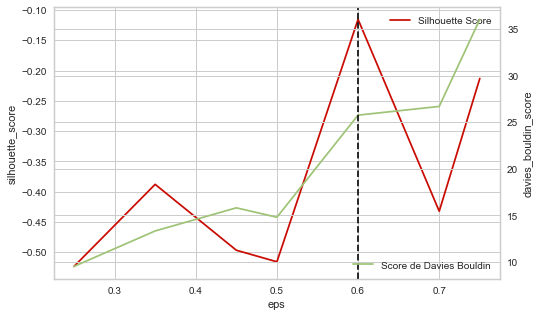

min_samples :  13
sil_norm eps
0.25    0.020620
0.35    0.232117
0.45    0.000000
0.50    0.281600
0.60    1.000000
0.70    0.676917
0.75    0.263338
Name: sil_norm, dtype: float64
boul_norm eps
0.25    1.000000
0.35    0.918309
0.45    0.892702
0.50    0.623000
0.60    0.202444
0.70    0.248965
0.75    0.000000
Name: boul_norm, dtype: float64
max eps
0.25    0.510310
0.35    0.575213
0.45    0.446351
0.50    0.452300
0.60    0.601222
0.70    0.462941
0.75    0.131669
Name: max, dtype: float64
best_score 0.6012218960426401
min_samples : 13
--------------------------
x :  Float64Index([0.6], dtype='float64', name='eps')


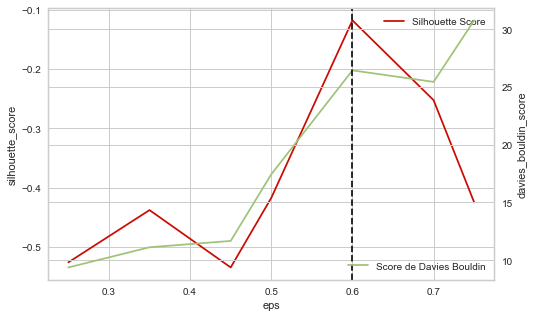

min_samples :  14
sil_norm eps
0.25    0.000000
0.35    0.134333
0.45    0.039400
0.50    0.245415
0.60    0.479388
0.70    1.000000
0.75    0.244683
Name: sil_norm, dtype: float64
boul_norm eps
0.25    1.000000
0.35    0.942172
0.45    0.841465
0.50    0.532865
0.60    0.496542
0.70    0.000000
0.75    0.068539
Name: boul_norm, dtype: float64
max eps
0.25    0.500000
0.35    0.538252
0.45    0.440433
0.50    0.389140
0.60    0.487965
0.70    0.500000
0.75    0.156611
Name: max, dtype: float64
best_score 0.5382524686662171
min_samples : 14
--------------------------
x :  Float64Index([0.35], dtype='float64', name='eps')


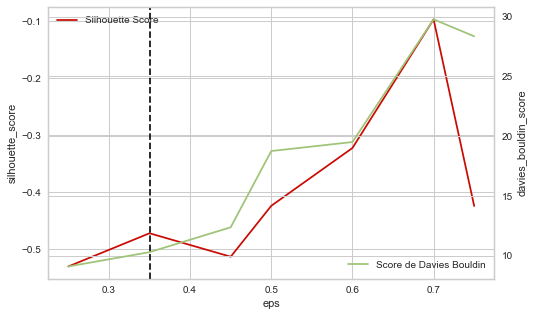

min_samples :  15
sil_norm eps
0.25    0.000000
0.35    0.124273
0.45    0.184282
0.50    0.315997
0.60    0.554765
0.70    1.000000
0.75    0.352492
Name: sil_norm, dtype: float64
boul_norm eps
0.25    1.000000
0.35    0.880722
0.45    0.773041
0.50    0.584443
0.60    0.442282
0.70    0.026668
0.75    0.000000
Name: boul_norm, dtype: float64
max eps
0.25    0.500000
0.35    0.502497
0.45    0.478662
0.50    0.450220
0.60    0.498524
0.70    0.513334
0.75    0.176246
Name: max, dtype: float64
best_score 0.5133341842708599
min_samples : 15
--------------------------
x :  Float64Index([0.7], dtype='float64', name='eps')


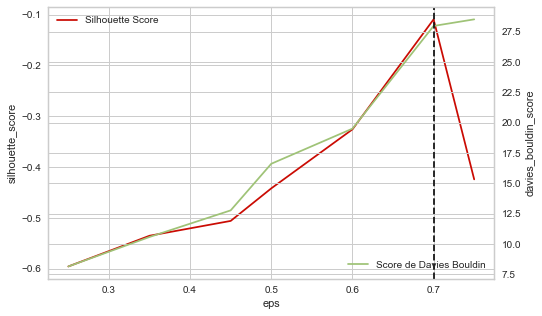

min_samples :  16
sil_norm eps
0.25    0.000000
0.35    0.113183
0.45    0.451980
0.50    0.452866
0.60    0.506383
0.70    0.958454
0.75    1.000000
Name: sil_norm, dtype: float64
boul_norm eps
0.25    1.000000
0.35    0.864906
0.45    0.737504
0.50    0.696691
0.60    0.586870
0.70    0.244793
0.75    0.000000
Name: boul_norm, dtype: float64
max eps
0.25    0.500000
0.35    0.489045
0.45    0.594742
0.50    0.574779
0.60    0.546626
0.70    0.601623
0.75    0.500000
Name: max, dtype: float64
best_score 0.6016233440579524
min_samples : 16
--------------------------
x :  Float64Index([0.7], dtype='float64', name='eps')


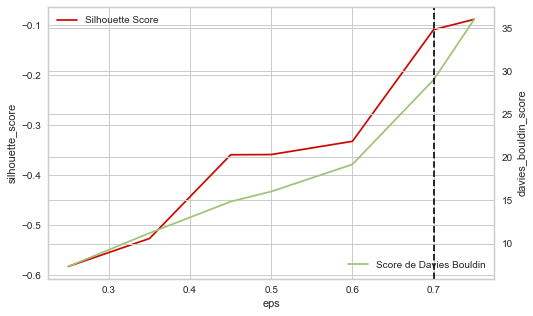

min_samples :  17
sil_norm eps
0.25    0.000000
0.35    0.029245
0.45    0.440641
0.50    0.582166
0.60    0.470903
0.70    0.958345
0.75    1.000000
Name: sil_norm, dtype: float64
boul_norm eps
0.25    1.000000
0.35    0.937612
0.45    0.706824
0.50    0.638287
0.60    0.620319
0.70    0.261950
0.75    0.000000
Name: boul_norm, dtype: float64
max eps
0.25    0.500000
0.35    0.483429
0.45    0.573733
0.50    0.610227
0.60    0.545611
0.70    0.610148
0.75    0.500000
Name: max, dtype: float64
best_score 0.6102267070301554
min_samples : 17
--------------------------
x :  Float64Index([0.5], dtype='float64', name='eps')


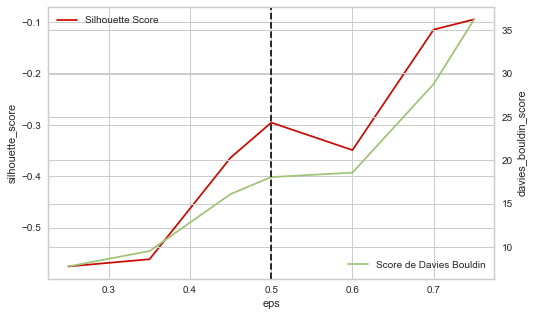

min_samples :  18
sil_norm eps
0.25    0.000000
0.35    0.000322
0.45    0.478372
0.50    0.574300
0.60    0.768104
0.70    0.980260
0.75    1.000000
Name: sil_norm, dtype: float64
boul_norm eps
0.25    1.000000
0.35    0.784892
0.45    0.538505
0.50    0.529165
0.60    0.385963
0.70    0.142464
0.75    0.000000
Name: boul_norm, dtype: float64
max eps
0.25    0.500000
0.35    0.392607
0.45    0.508438
0.50    0.551733
0.60    0.577033
0.70    0.561362
0.75    0.500000
Name: max, dtype: float64
best_score 0.5770332456195449
min_samples : 18
--------------------------
x :  Float64Index([0.6], dtype='float64', name='eps')


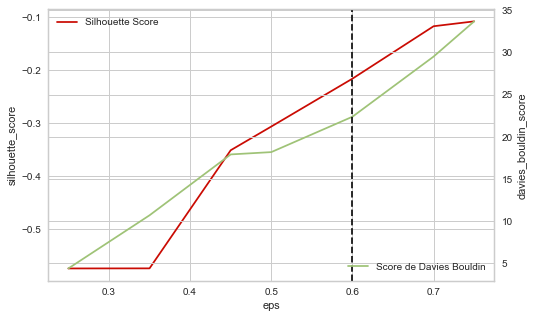

min_samples :  19
sil_norm eps
0.25    0.000000
0.35    0.041798
0.45    0.809173
0.50    0.923202
0.60    0.427027
0.70    0.963511
0.75    1.000000
Name: sil_norm, dtype: float64
boul_norm eps
0.25    1.000000
0.35    0.752399
0.45    0.403467
0.50    0.423856
0.60    0.276473
0.70    0.162977
0.75    0.000000
Name: boul_norm, dtype: float64
max eps
0.25    0.500000
0.35    0.397099
0.45    0.606320
0.50    0.673529
0.60    0.351750
0.70    0.563244
0.75    0.500000
Name: max, dtype: float64
best_score 0.673529055283513
min_samples : 19
--------------------------
x :  Float64Index([0.5], dtype='float64', name='eps')


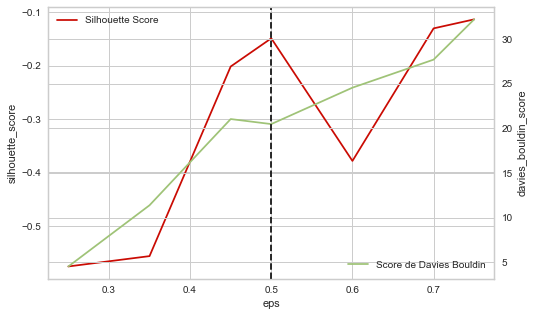

min_samples :  20
sil_norm eps
0.25    0.000000
0.35    0.016191
0.45    0.807647
0.50    0.608899
0.60    0.351485
0.70    0.965966
0.75    1.000000
Name: sil_norm, dtype: float64
boul_norm eps
0.25    1.000000
0.35    0.789761
0.45    0.441288
0.50    0.583856
0.60    0.458130
0.70    0.204670
0.75    0.000000
Name: boul_norm, dtype: float64
max eps
0.25    0.500000
0.35    0.402976
0.45    0.624468
0.50    0.596377
0.60    0.404807
0.70    0.585318
0.75    0.500000
Name: max, dtype: float64
best_score 0.6244676468263455
min_samples : 20
--------------------------
x :  Float64Index([0.45], dtype='float64', name='eps')


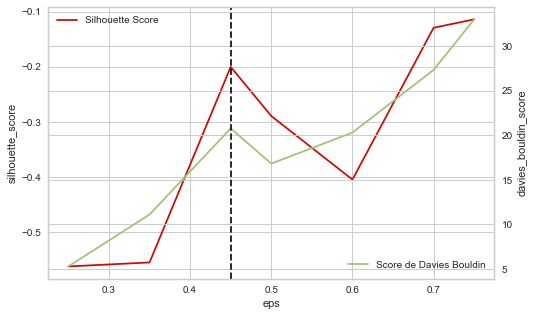

In [319]:
# affichage des résultats sur des graphiques
df_best_dbscan = pd.DataFrame(columns=['min_samples', 'max_norm', 'eps'])

# n_clust = df_res_clustering_dbscan['n_clusters'].unique()


for ms in min_samples:
    print('min_samples : ', ms)
    mini_res = df_res_clustering_dbscan[df_res_clustering_dbscan['min_samples'] == ms].copy()
    mini_res['sil_norm'] = _norm(mini_res, 'silhouette_score')
    print('sil_norm', mini_res['sil_norm'])
    mini_res['boul_norm'] = 1 - _norm(mini_res, 'davies_bouldin_score')
    print('boul_norm', mini_res['boul_norm'])
    mini_res['max'] = mini_res['sil_norm'] * 0.5 +  mini_res['boul_norm'] * 0.5
    print('max', mini_res['max'])
    best_score = mini_res['max'].max()
    print('best_score', best_score)
    eps_courant = (mini_res[mini_res['max'] == best_score].index).array
    
#     
    cluster_list = (mini_res[mini_res['max'] == best_score]['n_clusters']).tolist()
    if len(cluster_list) > 1:
        print(f"{bcolors.WARNING}'Erreur !!! len = {len(cluster_list)}{bcolors.ENDC}")
        break
    
    if cluster_list[0] > 2:
        df_best_dbscan = df_best_dbscan.append({'min_samples':ms, 'max_norm':best_score, 'eps':eps_courant[0]}, ignore_index=True)
    #     print('max de score de silhouette est', max_silhoutte, 'lorsque le nombre de clusters est à ', 
    #           mini_res[mini_res['silhouette_score'] == max_silhoutte].index)
    #     min_bouldin = mini_res['davies_bouldin_score'].min()
    #     print('min de score de davies bouldin est', min_bouldin, 'lorsque le nombre de clusters est à ', 
    #           mini_res[mini_res['davies_bouldin_score'] == min_bouldin].index)
        print('min_samples :', ms)

    fig = plt.figure(figsize=(8,5))

    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    mini_res.plot(ax=ax1, y='silhouette_score', color='r',label='Silhouette Score')
    mini_res.plot(ax=ax2, y='davies_bouldin_score', color='g',label='Score de Davies Bouldin')
    plt.gca().legend(loc=4)
    plt.xlabel("epsilon")
    #     plt.ylabel("Silhouette & Davies Bouldin Scores")
    ax1.set_ylabel('silhouette_score')
    ax2.set_ylabel('davies_bouldin_score')
#     plt.legend(loc='best')
    #     fig.add_subplot(223)
    x = mini_res[mini_res['max'] == best_score].index
    print('--------------------------')
    print('x : ', x)

    if len(x):
        plt.axvline(x, color='k', linestyle='--')


#     plt.ylabel("Davies Bouldin score")
#     plt.legend()

    plt.show()

In [229]:
(mini_res[mini_res['max'] == best_score]['n_clusters']).tolist()

[1.0]

In [321]:
df_res_clustering_dbscan

min_samples  n_clusters  silhouette_score  davies_bouldin_score
eps                                                                  
0.25         12.0        11.0         -0.523462              9.522053
0.25         13.0        11.0         -0.526252              9.370669
0.25         14.0        12.0         -0.530800              9.097371
0.25         15.0        14.0         -0.595414              8.135650
0.25         16.0        14.0         -0.582198              7.343089
...           ...         ...               ...                   ...
0.75         16.0         5.0         -0.088448             35.996146
0.75         17.0         5.0         -0.094447             36.233951
0.75         18.0         5.0         -0.107411             33.691152
0.75         19.0         5.0         -0.112930             32.193733
0.75         20.0         5.0         -0.113989             33.020977

[63 rows x 4 columns]

In [320]:
df_best_dbscan.style.highlight_max(subset=['max_norm'], color='#6EA4EC')

In [322]:
df_res_clustering_dbscan[(df_res_clustering_dbscan.index == 0.60) & (df_res_clustering_dbscan['min_samples'] == 12)]

min_samples  n_clusters  silhouette_score  davies_bouldin_score
eps                                                                 
0.6         12.0         5.0         -0.115499             25.759118

In [323]:
clustering_dbscan = DBSCAN(eps=0.60, min_samples=12)
estimator_dbscan = make_pipeline(StandardScaler(), clustering_dbscan).fit(X_10perc_sample)
labels_dbscan = clustering_dbscan.labels_
print('nombre de population des clusters : ', pd.Series(labels_dbscan).value_counts())
# calcul des scores
db_score = davies_bouldin_score(X_10perc_sample, labels_dbscan)
silh_score = metrics.silhouette_score(X_10perc_sample, labels_dbscan, metric='euclidean')

nombre de population des clusters :   0    5118
 2    1753
-1     855
 4     727
 1     691
 3     190
dtype: int64


In [324]:
print('Score Davis Bouldin : ', db_score, 'Score de silhouette : ', silh_score)

Score Davis Bouldin :  25.759118431217075 Score de silhouette :  -0.11549906821287098


In [325]:
pd.Series(labels_dbscan).nunique()

6

## Visualisation de clusters DBscan obtenus <a class="anchor" id="dbscan_viz"></a>

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

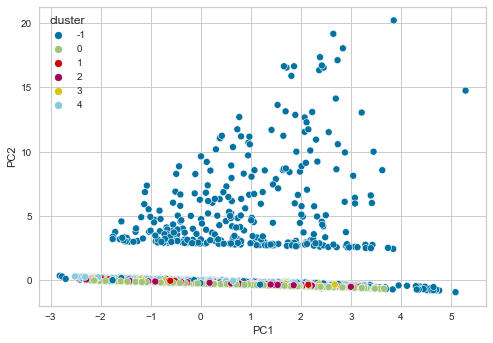

In [326]:
pca_X10perc = pd.DataFrame(PCA(n_components=2).fit_transform(X_10perc_sample_scaled),columns=['PC1','PC2'])
pca_X10perc['cluster'] = pd.Categorical(labels_dbscan)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_X10perc)

<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

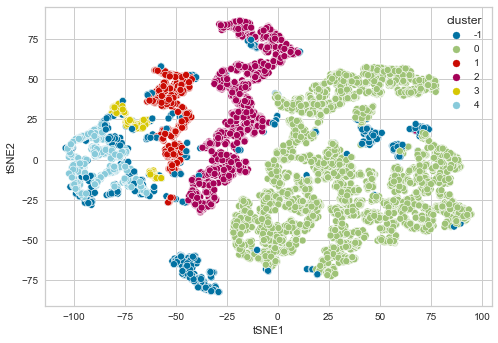

In [327]:
# affichage tSNE
tsne_affichage = TSNE(n_components=2)
X_10perc_tsne = pd.DataFrame(tsne_affichage.fit_transform(X_10perc_sample_scaled),columns=['tSNE1','tSNE2'])
X_10perc_tsne['cluster'] = pd.Categorical(labels_dbscan)
sns.scatterplot(x="tSNE1",y="tSNE2",hue="cluster",data=X_10perc_tsne)

## Analyse des 5 clusters obtenus <a class="anchor" id="dbscan_analysis"></a>

In [333]:
np.unique(labels_dbscan)

array([-1,  0,  1,  2,  3,  4], dtype=int64)

In [334]:
pd.Categorical(labels_dbscan)

[0, 0, 0, 0, 1, ..., 0, 0, 0, 0, -1]
Length: 9334
Categories (6, int64): [-1, 0, 1, 2, 3, 4]

In [343]:
X_10perc_sample_clustered = X_10perc_sample.copy()

In [344]:
X_10perc_sample_clustered["cluster_dbscan"] = pd.Categorical(labels_dbscan)

<Figure size 576x396 with 0 Axes>

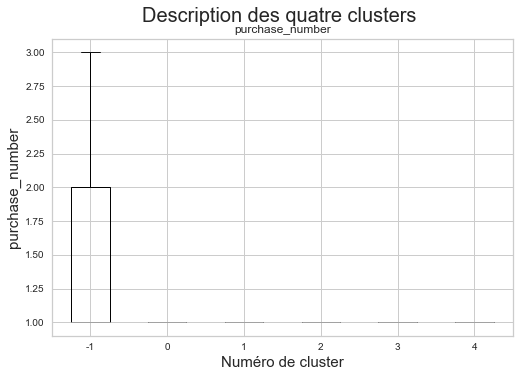

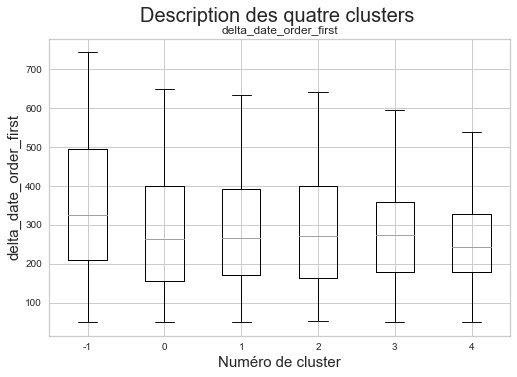

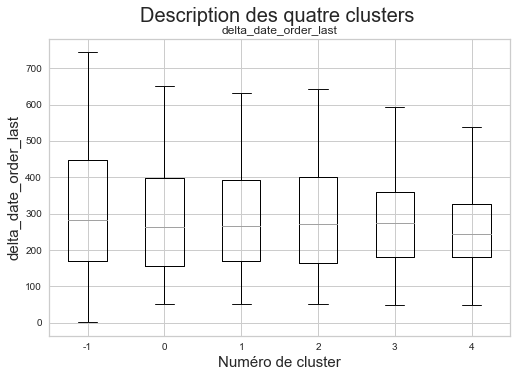

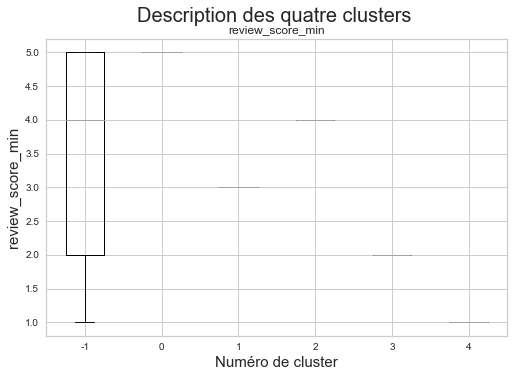

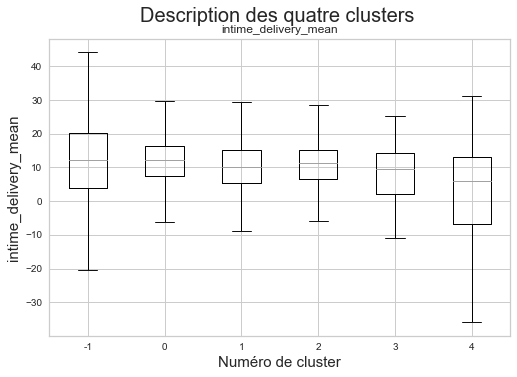

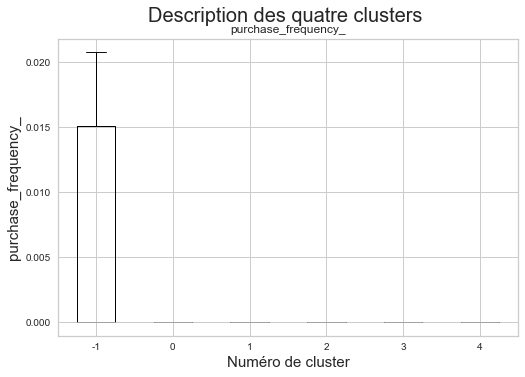

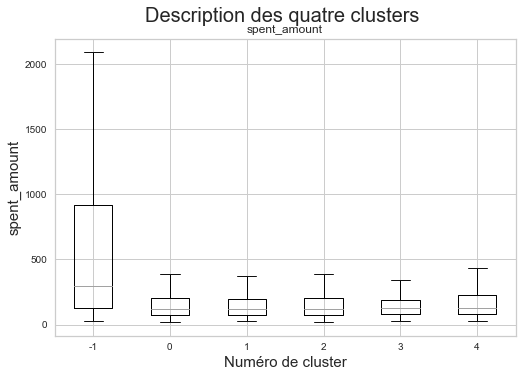

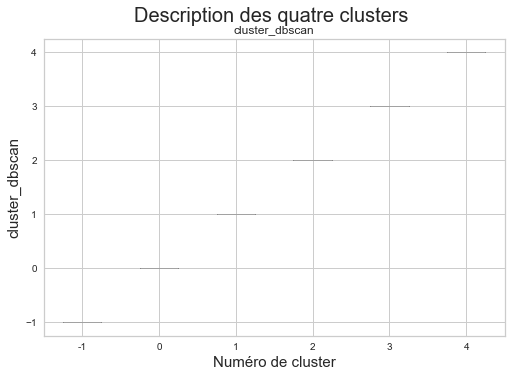

In [345]:
plt.figure()

for col in X_10perc_sample_clustered.columns:
    X_10perc_sample_clustered.boxplot(column=[col], by= X_10perc_sample_clustered['cluster_dbscan'], showfliers=False)
# plt.title('AAA')
    plt.suptitle('Description des quatre clusters ', fontsize = 20) # 
    plt.xlabel('Numéro de cluster', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel(f'{col}', fontsize = 15) # y-axis label with fontsize 15
    plt.show()

Séparation en fonction de la note du client donné dans son retour.

In [346]:
X_10perc_tsne['cluster_name'] = np.where((X_10perc_tsne['cluster'] == -1),'bruit_clients_ancients_actifs', X_10perc_tsne['cluster'])

In [347]:
X_10perc_tsne['cluster_name'] = np.where((X_10perc_tsne['cluster'] == 0),'review_note_5', X_10perc_tsne['cluster_name'])

In [348]:
X_10perc_tsne['cluster_name'] = np.where((X_10perc_tsne['cluster'] == 1),'review_note_3', X_10perc_tsne['cluster_name'])

In [349]:
X_10perc_tsne['cluster_name'] = np.where((X_10perc_tsne['cluster'] == 2),'review_note_4', X_10perc_tsne['cluster_name'])

In [350]:
X_10perc_tsne['cluster_name'] = np.where((X_10perc_tsne['cluster'] == 3),'review_note_2', X_10perc_tsne['cluster_name'])

In [351]:
X_10perc_tsne['cluster_name'] = np.where((X_10perc_tsne['cluster'] == 4),'review_note_1_nouveau_client', X_10perc_tsne['cluster_name'])

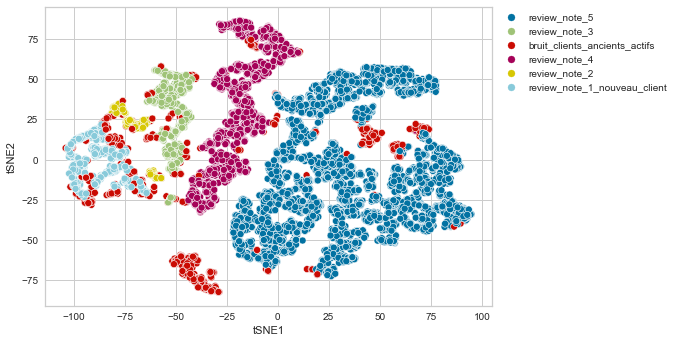

In [353]:
sns.scatterplot(x="tSNE1",y="tSNE2",hue="cluster_name",data=X_10perc_tsne)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.01), frameon=False)

# Test de RobustScaler <a class="anchor" id="robust_scaler"></a>

In [356]:
robustscale_X_50perc_sample = preprocessing.RobustScaler().fit(X_50perc_sample)
X50perc_robustscaled = robustscale_X_50perc_sample.transform(X_50perc_sample)

In [374]:
acp = PCA(n_components=7)

In [375]:
acp.fit(X50perc_robustscaled)

PCA(n_components=7)

In [376]:
pcs = acp.components_

(-0.7, 0.7)

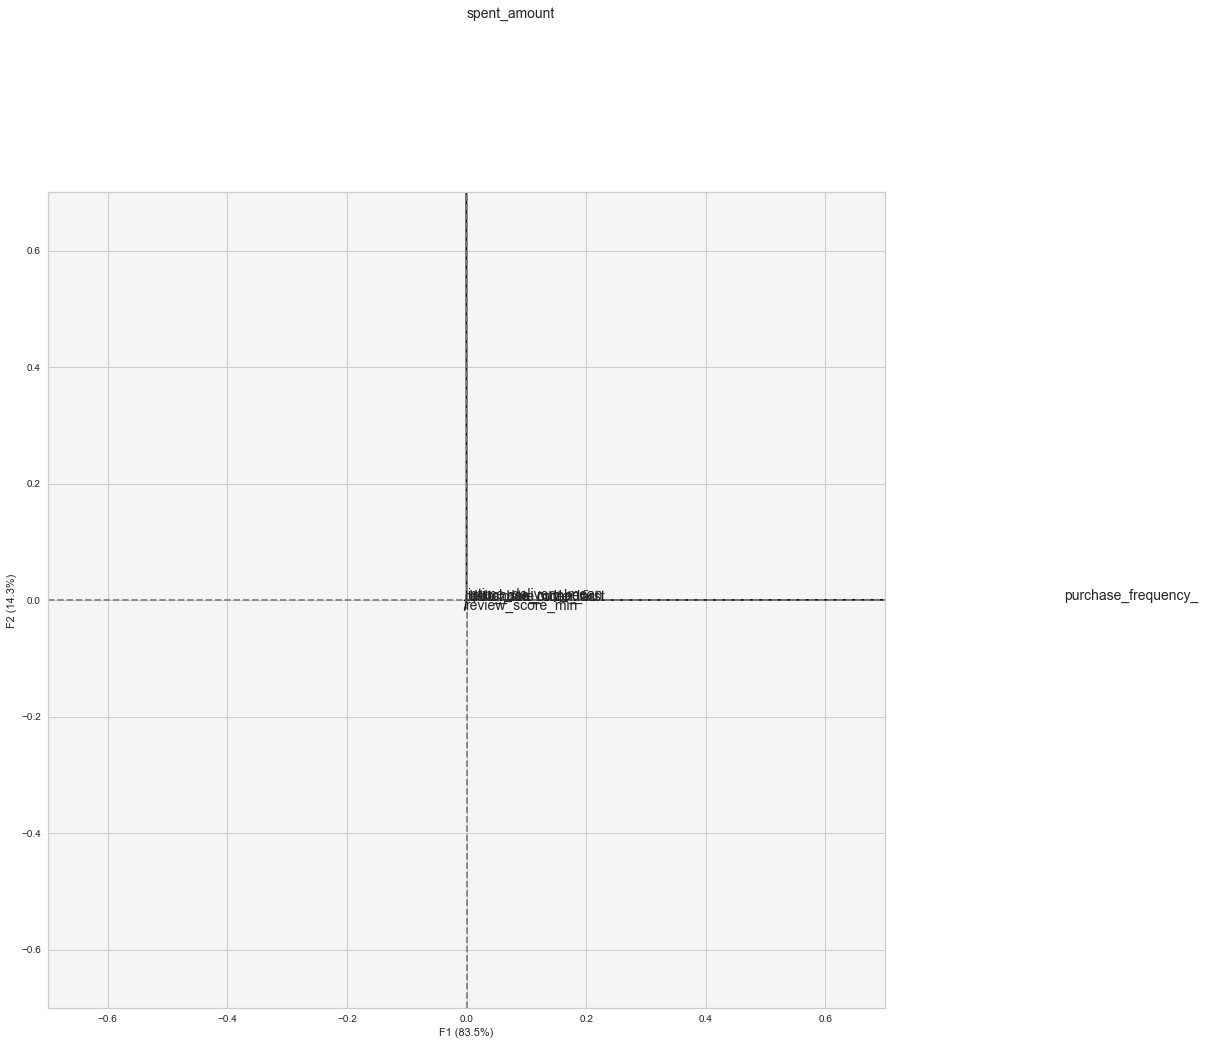

In [377]:
fig = plt.figure(figsize=(15,15))
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, X.columns[i], fontsize='14')

    
ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(0+1, round(100*acp.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(1+1, round(100*acp.explained_variance_ratio_[1],1)))

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

In [358]:
#RobustScaler(), PCA(n_components=n)

df_res_robust_kmeans = pd.DataFrame(columns=['n_components', 'n_clusters', 'inertia', 'silhouette_score', 'davies_bouldin_score'])


for n in range(2,8):
    for k in range(3,8):
        pca = PCA(n_components=n)
        kmeans = KMeans(n_clusters=k, max_iter=1000)
        estimator = make_pipeline(RobustScaler(), pca, kmeans).fit(X_50perc_sample)
        labels_k = kmeans.labels_
        #print(data["clusters"])
        inert = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center = SSE
        db_score = davies_bouldin_score(X_50perc_sample, labels_k)
        silh_score = metrics.silhouette_score(X_50perc_sample, labels_k, metric='euclidean')
        df_res_robust_kmeans = df_res_robust_kmeans.append({'n_components':n, 'n_clusters':k, 'inertia':inert, 'silhouette_score':silh_score,
                                          'davies_bouldin_score':db_score}, ignore_index=True)
df_res_robust_kmeans = df_res_robust_kmeans.set_index('n_clusters')

In [364]:
# fonction pour faire des graphiques de résultats pour kmeans

def plotscore_kmeans (df_res_kmeans,n):
    df_best_res = pd.DataFrame(columns=['n_components', 'max_norm', 'k_cluster'])

    for n in range(2,n):
        mini_res = df_res_kmeans[df_res_kmeans['n_components'] == n].copy()
        max_silhoutte = mini_res['silhouette_score'].max()
        mini_res['sil_norm'] = _norm(mini_res, 'silhouette_score')
        mini_res['boul_norm'] = 1 - _norm(mini_res, 'davies_bouldin_score')
        mini_res['max'] = mini_res['sil_norm'] * 0.5 +  mini_res['boul_norm'] * 0.5
        best_score = mini_res['max'].max()
        best_k = (mini_res[mini_res['max'] == best_score].index).array

        df_best_res = df_best_res.append({'n_components':n, 'max_norm':best_score, 'k_cluster':best_k[0]}, ignore_index=True)
    #     print('max de score de silhouette est', max_silhoutte, 'lorsque le nombre de clusters est à ', 
    #           mini_res[mini_res['silhouette_score'] == max_silhoutte].index)
    #     min_bouldin = mini_res['davies_bouldin_score'].min()
    #     print('min de score de davies bouldin est', min_bouldin, 'lorsque le nombre de clusters est à ', 
    #           mini_res[mini_res['davies_bouldin_score'] == min_bouldin].index)
        print('n_components :', n)
        plot_score(mini_res, best_k)
    return df_best_res.style.highlight_max(subset=['max_norm'], color='#6EA4EC')

In [361]:
df_res_robust_kmeans

n_components       inertia  silhouette_score  davies_bouldin_score
n_clusters                                                                    
3.0                  2.0  1.712692e+06          0.000254              3.447173
4.0                  2.0  1.125775e+06          0.006602              2.573740
5.0                  2.0  8.663383e+05         -0.032533              3.965781
6.0                  2.0  6.279656e+05          0.010496              3.222331
7.0                  2.0  4.962018e+05          0.000379              3.569153
3.0                  3.0  1.799081e+06          0.000254              3.447173
4.0                  3.0  1.212101e+06          0.006602              2.573740
5.0                  3.0  9.526358e+05         -0.032533              3.965781
6.0                  3.0  7.144509e+05          0.010065              3.179799
7.0                  3.0  5.824884e+05          0.000379              3.569153
3.0                  4.0  1.843957e+06          0.000254              3.447173
4.0                  4.0  1.256955e+06          0.006602              2.573740
5.0                  4.0  9.976772e+05         -0.032961              3.897016
6.0                  4.0  7.591150e+05          0.010496              3.222331
7.0                  4.0  6.273409e+05          0.000379              3.569153
3.0                  5.0  1.880454e+06          0.000254              3.447173
4.0                  5.0  1.293430e+06          0.006602              2.573740
5.0                  5.0  1.033960e+06         -0.032533              3.965781
6.0                  5.0  7.955865e+05          0.010496              3.222331
7.0                  5.0  6.638105e+05          0.000379              3.569153
3.0                  6.0  1.882011e+06          0.000254              3.447173
4.0                  6.0  1.294986e+06          0.006602              2.573740
5.0                  6.0  1.035359e+06         -0.032533              3.965781
6.0                  6.0  7.969862e+05          0.010496              3.222331
7.0                  6.0  6.651819e+05          0.000379              3.569153
3.0                  7.0  1.882017e+06          0.000254              3.447173
4.0                  7.0  1.294992e+06          0.006602              2.573740
5.0                  7.0  1.035365e+06         -0.032533              3.965781
6.0                  7.0  7.969922e+05          0.010496              3.222331
7.0                  7.0  6.651878e+05          0.000379              3.569153

n_components : 2


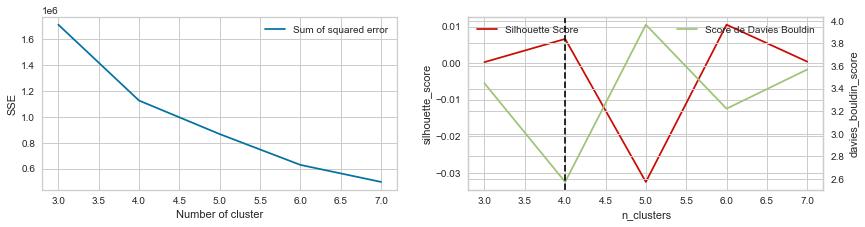

n_components : 3


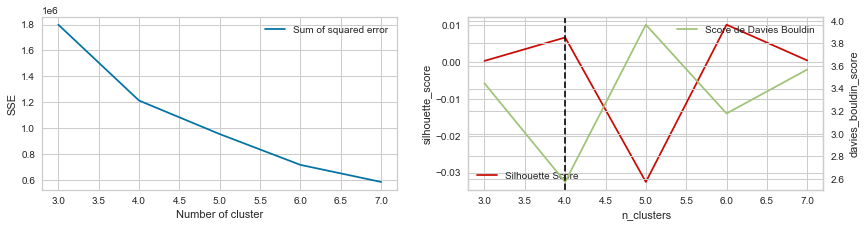

n_components : 4


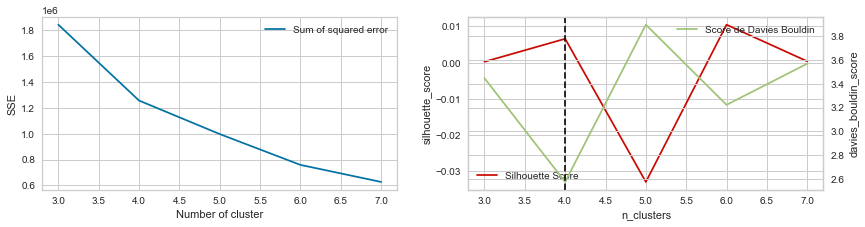

n_components : 5


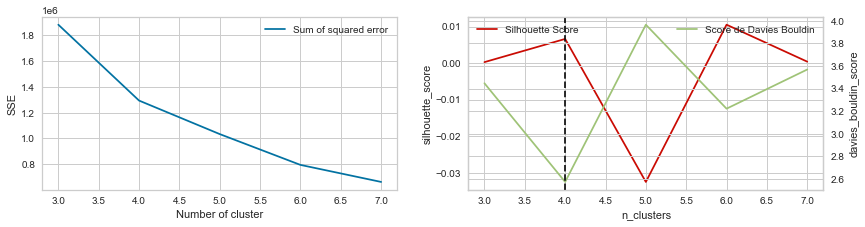

n_components : 6


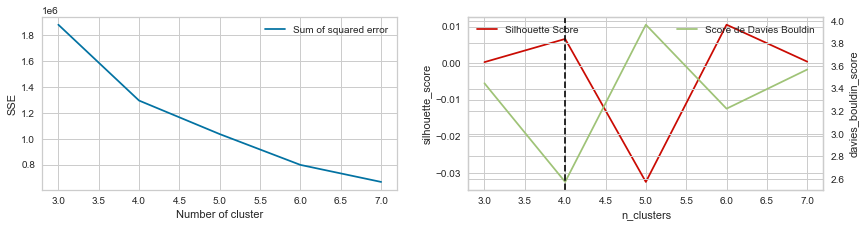

n_components : 7


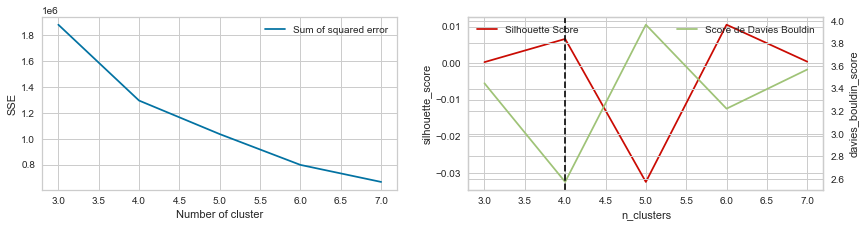

In [365]:
plotscore_kmeans(df_res_robust_kmeans, 8)

For n_clusters = 4 The average silhouette_score is : 0.9669369813843449


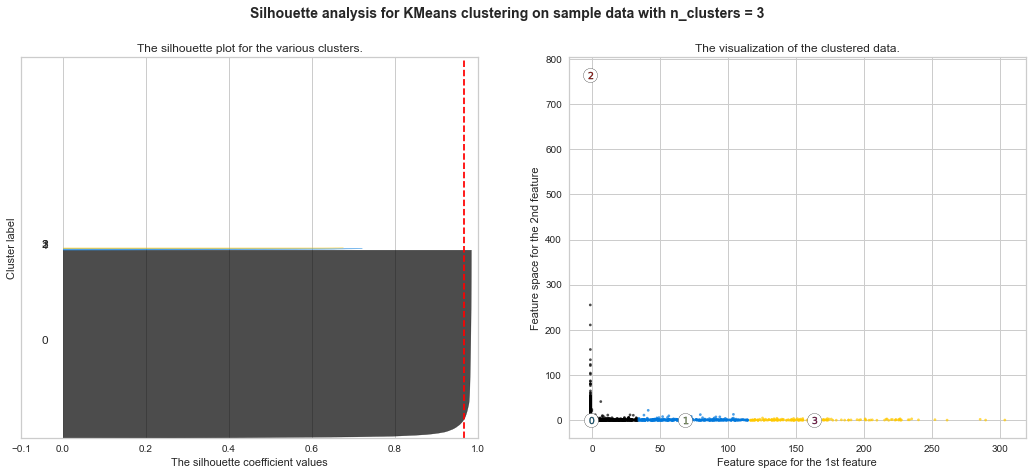

In [366]:
# RobustScaler()
# Create a subplot with 1 row and 2 columns
n_clusters = 4
n_components = 3
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (3 + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
reduced_data = PCA(n_components=2).fit_transform(X50perc_robustscaled)
kmeans = KMeans(n_clusters=n_clusters)
# kmeans.fit(reduced_data)
estimator_RobustScaler = make_pipeline(RobustScaler(), PCA(n_components=n_components), kmeans).fit(X_50perc_sample)
cluster_labels = kmeans.labels_

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(reduced_data, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = 3"),
             fontsize=14, fontweight='bold')

plt.show()

<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

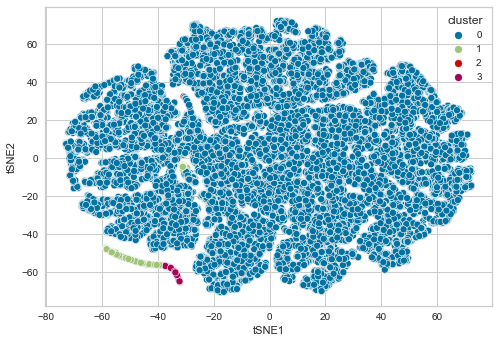

In [367]:
# affichage tSNE
# tsne_affichage = TSNE(n_components=2)
X50perc_robustscaled_tsne = pd.DataFrame(tsne_affichage.fit_transform(X50perc_robustscaled),columns=['tSNE1','tSNE2'])
X50perc_robustscaled_tsne['cluster'] = pd.Categorical(cluster_labels)
sns.scatterplot(x="tSNE1",y="tSNE2",hue="cluster",data=X50perc_robustscaled_tsne)

In [378]:
X50perc_robustscaled_clusted = X_50perc_sample.copy()

In [379]:
X50perc_robustscaled_clusted['clusters_robustsc_kmeans']= pd.Categorical(cluster_labels)

<Figure size 576x396 with 0 Axes>

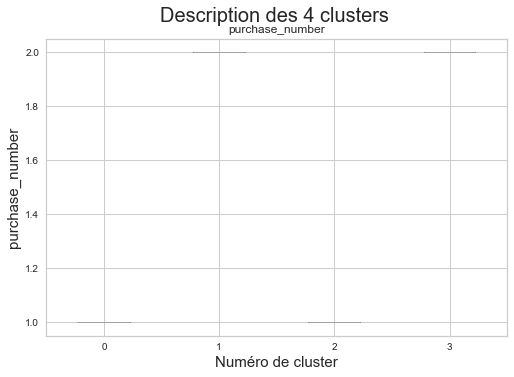

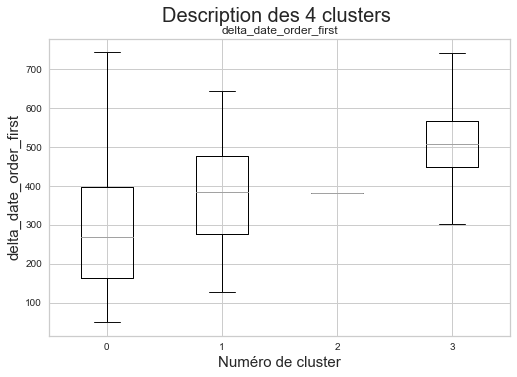

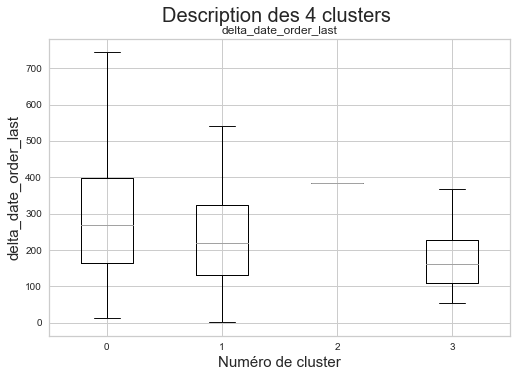

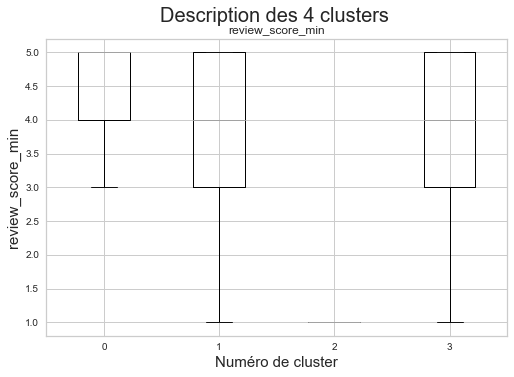

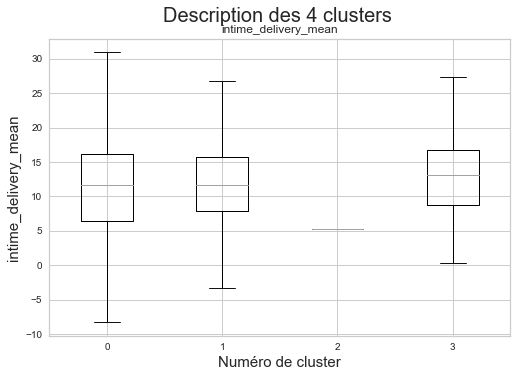

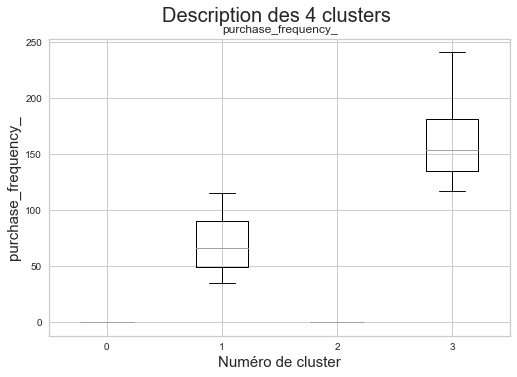

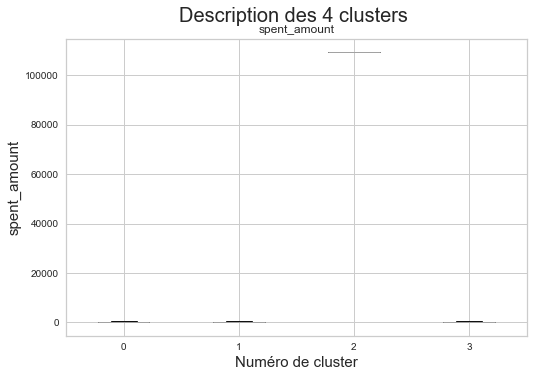

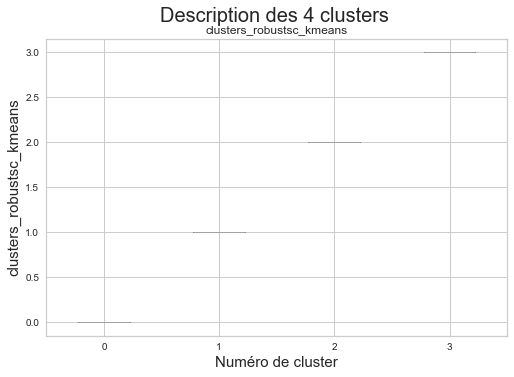

In [380]:
plt.figure()

for col in X50perc_robustscaled_clusted.columns:
    X50perc_robustscaled_clusted.boxplot(column=[col], by= X50perc_robustscaled_clusted['clusters_robustsc_kmeans'], showfliers=False)
# plt.title('AAA')
    plt.suptitle(f'Description des {len(np.unique(cluster_labels))} clusters ', fontsize = 20) # 
    plt.xlabel('Numéro de cluster', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel(f'{col}', fontsize = 15) # y-axis label with fontsize 15
    plt.show()

# Test de QuantileTransformer <a class="anchor" id="quantile_transformer"></a>

In [381]:
#qt = QuantileTransformer(n_quantiles=10, random_state=0)
quantrans_X_50perc_sample = preprocessing.QuantileTransformer(random_state=0).fit(X_50perc_sample)
X50perc_quantrans = quantrans_X_50perc_sample.transform(X_50perc_sample)

In [382]:
pca_quant = PCA(n_components=7)

In [383]:
pca_quant.fit(X50perc_quantrans)

PCA(n_components=7)

In [384]:
pcs_quant = pca_quant.components_

In [386]:
# pcs=pca.components_; d1, d2: dimentions
def project_pca(pcs, d1, d2):
    fig = plt.figure(figsize=(15,15))
    for i, (x, y) in enumerate(zip(pcs[d1, :], pcs[d2, :])):
        # Afficher un segment de l'origine au point (x, y)
        plt.plot([0, x], [0, y], color='k')
        # Afficher le nom (data.columns[i]) de la performance
        plt.text(x, y, X.columns[i], fontsize='14')


    ax = plt.gca()
    ax.set_facecolor('whitesmoke')

    # Afficher une ligne horizontale y=0
    plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

    # Afficher une ligne verticale x=0
    plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(0+1, round(100*acp.explained_variance_ratio_[d1],1)))
    plt.ylabel('F{} ({}%)'.format(1+1, round(100*acp.explained_variance_ratio_[d2],1)))

    plt.xlim([-0.7, 0.7])
    plt.ylim([-0.7, 0.7])

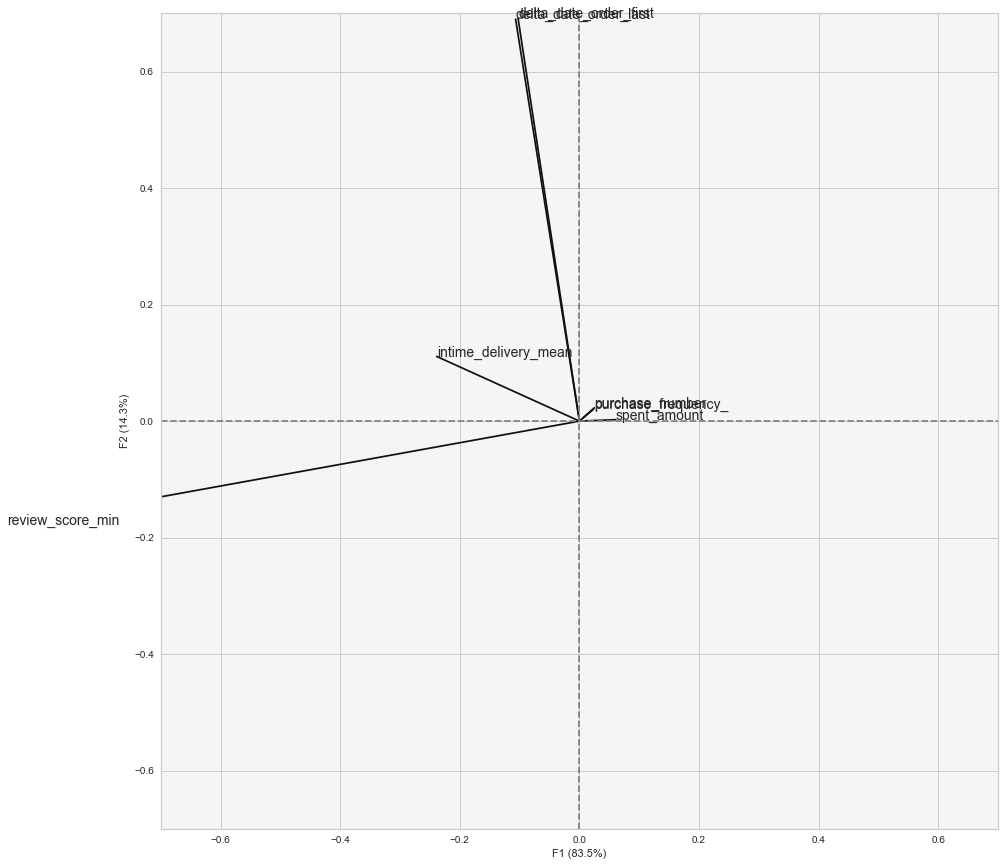

In [387]:
project_pca(pcs_quant,0,1)

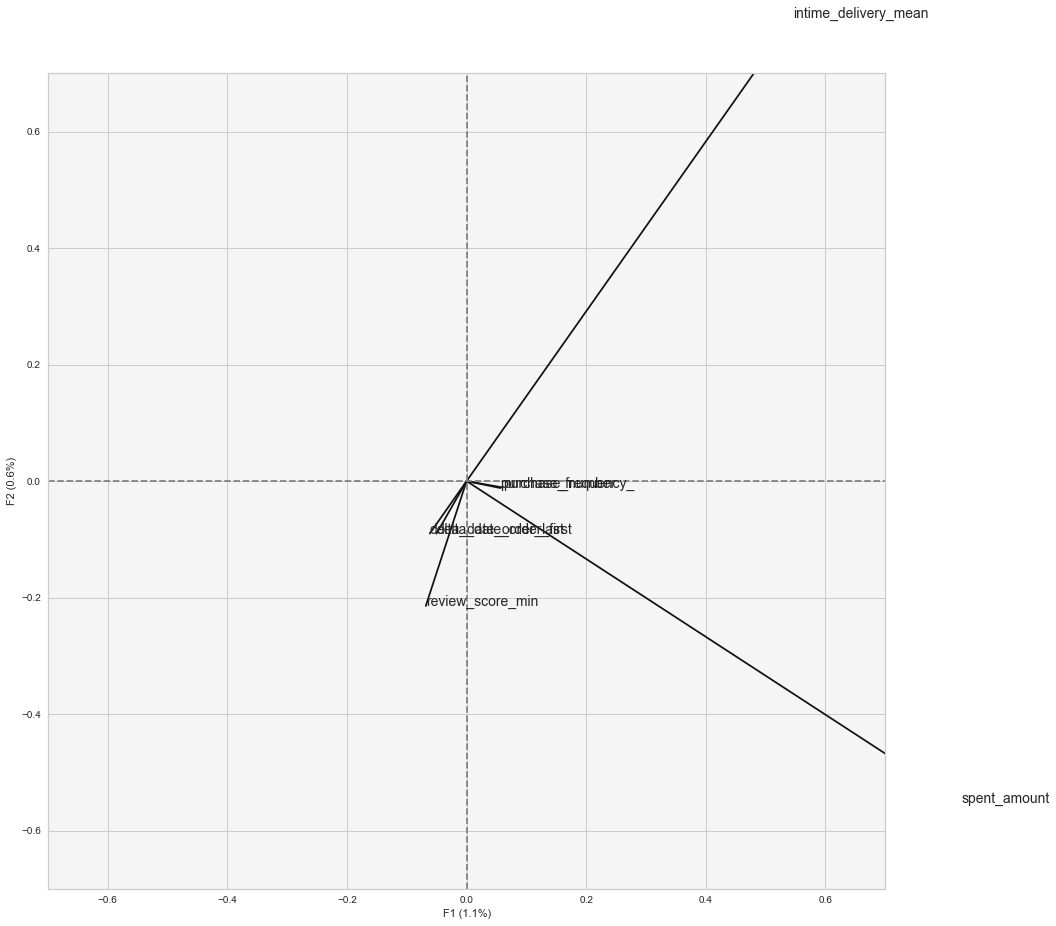

In [388]:
project_pca(pcs_quant,2,3)

In [389]:
#QuantileTransformer(random_state=0), PCA(n_components=n)

df_res_quantrans_kmeans = pd.DataFrame(columns=['n_components', 'n_clusters', 'inertia', 'silhouette_score',
                                                'davies_bouldin_score'])


for n in range(2,8):
    for k in range(3,8):
        pca = PCA(n_components=n)
        kmeans = KMeans(n_clusters=k, max_iter=1000)
        estimator = make_pipeline(QuantileTransformer(random_state=0), pca, kmeans).fit(X_50perc_sample)
        labels_k = kmeans.labels_
        #print(data["clusters"])
        inert = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center = SSE
        db_score = davies_bouldin_score(X_50perc_sample, labels_k)
        silh_score = metrics.silhouette_score(X_50perc_sample, labels_k, metric='euclidean')
        df_res_quantrans_kmeans = df_res_quantrans_kmeans.append({'n_components':n, 'n_clusters':k, 'inertia':inert, 'silhouette_score':silh_score,
                                          'davies_bouldin_score':db_score}, ignore_index=True)
df_res_quantrans_kmeans = df_res_quantrans_kmeans.set_index('n_clusters')

In [431]:
X_50perc_sample

purchase_number  delta_date_order_first  delta_date_order_last  \
55876                1              160.205162             160.205162   
86488                1              254.724086             254.724086   
78366                1               64.033345              64.033345   
41490                1              320.868669             320.868669   
44306                1               67.164213              67.164213   
...                ...                     ...                    ...   
45240                1               63.697164              63.697164   
51500                1              387.091921             387.091921   
87846                1               65.817361              65.817361   
19247                1               74.975475              74.975475   
33984                1              181.298646             181.298646   

       review_score_min  intime_delivery_mean  purchase_frequency_  \
55876                 5             15.997940                  0.0   
86488                 5             21.099618                  0.0   
78366                 5              6.997164                  0.0   
41490                 5             21.130567                  0.0   
44306                 3              3.962569                  0.0   
...                 ...                   ...                  ...   
45240                 4              3.255926                  0.0   
51500                 3             13.180509                  0.0   
87846                 5              5.285694                  0.0   
19247                 5              5.213414                  0.0   
33984                 4             11.993819                  0.0   

       spent_amount  
55876        179.38  
86488         58.74  
78366        152.08  
41490        267.80  
44306        103.80  
...             ...  
45240        140.66  
51500        237.20  
87846        209.15  
19247        205.78  
33984        227.38  

[46671 rows x 7 columns]

n_components : 2


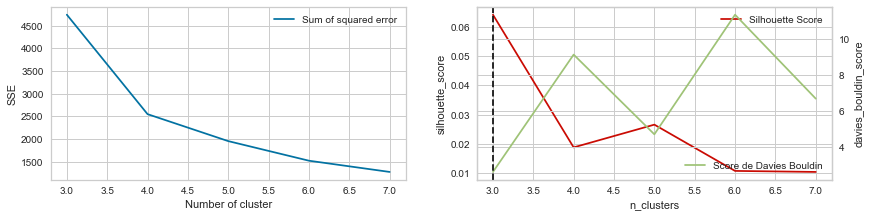

n_components : 3


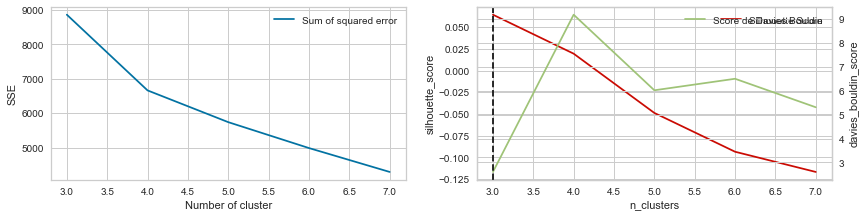

n_components : 4


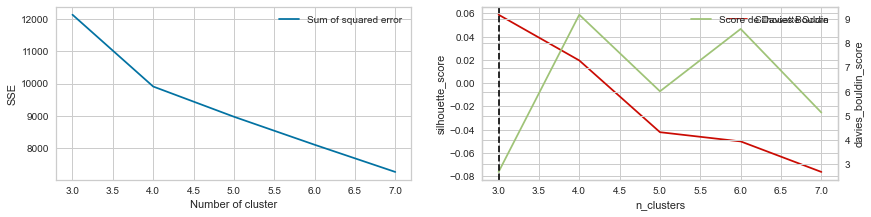

n_components : 5


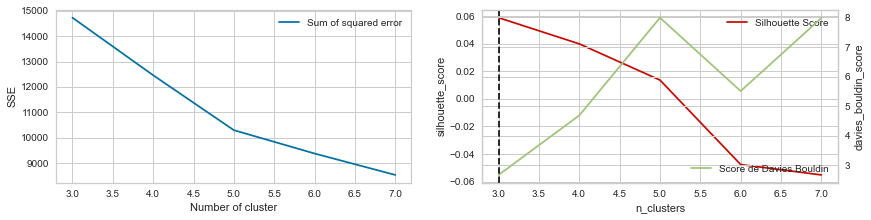

n_components : 6


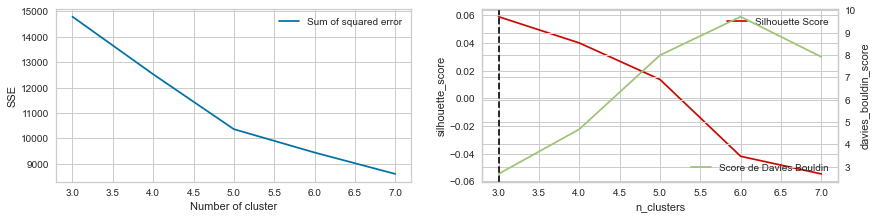

n_components : 7


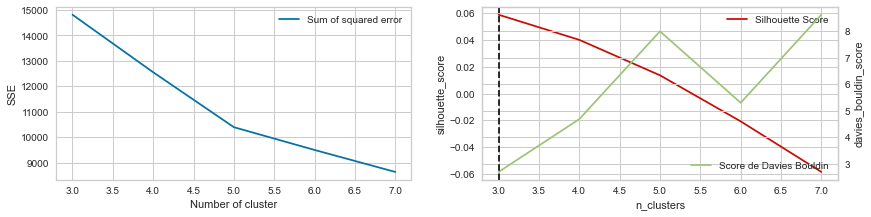

In [390]:
plotscore_kmeans(df_res_quantrans_kmeans, 8)

In [391]:
df_res_quantrans_kmeans

n_components       inertia  silhouette_score  davies_bouldin_score
n_clusters                                                                    
3.0                  2.0   4745.747699          0.064084              2.615995
4.0                  2.0   2550.701621          0.018861              9.141150
5.0                  2.0   1955.268819          0.026615              4.707763
6.0                  2.0   1522.706655          0.010841             11.360049
7.0                  2.0   1274.875120          0.010494              6.691574
3.0                  3.0   8862.212603          0.064373              2.605038
4.0                  3.0   6663.138726          0.019465              9.169615
5.0                  3.0   5740.877564         -0.048841              6.014080
6.0                  3.0   4988.403094         -0.093548              6.495128
7.0                  3.0   4294.608448         -0.116824              5.305074
3.0                  4.0  12131.829162          0.058968              2.678127
4.0                  4.0   9908.761272          0.019599              9.185469
5.0                  4.0   8974.100936         -0.042134              6.014300
6.0                  4.0   8106.607452         -0.050067              8.596407
7.0                  4.0   7264.462964         -0.076330              5.135298
3.0                  5.0  14724.418252          0.058832              2.681207
4.0                  5.0  12461.290461          0.039865              4.690017
5.0                  5.0  10299.765134          0.013610              7.989204
6.0                  5.0   9381.560681         -0.047630              5.512751
7.0                  5.0   8538.777317         -0.055166              7.978665
3.0                  6.0  14788.031219          0.058909              2.679275
4.0                  6.0  12524.034992          0.039946              4.677371
5.0                  6.0  10362.116797          0.013559              7.988722
6.0                  6.0   9443.327828         -0.041983              9.710235
7.0                  6.0   8600.898389         -0.054727              7.912221
3.0                  7.0  14817.533227          0.058722              2.684993
4.0                  7.0  12553.526748          0.039979              4.676343
5.0                  7.0  10391.613356          0.013563              7.989618
6.0                  7.0   9495.599329         -0.020744              5.294359
7.0                  7.0   8631.109213         -0.058437              8.615782

For n_clusters = 3 The average silhouette_score is : 0.5104795051134284


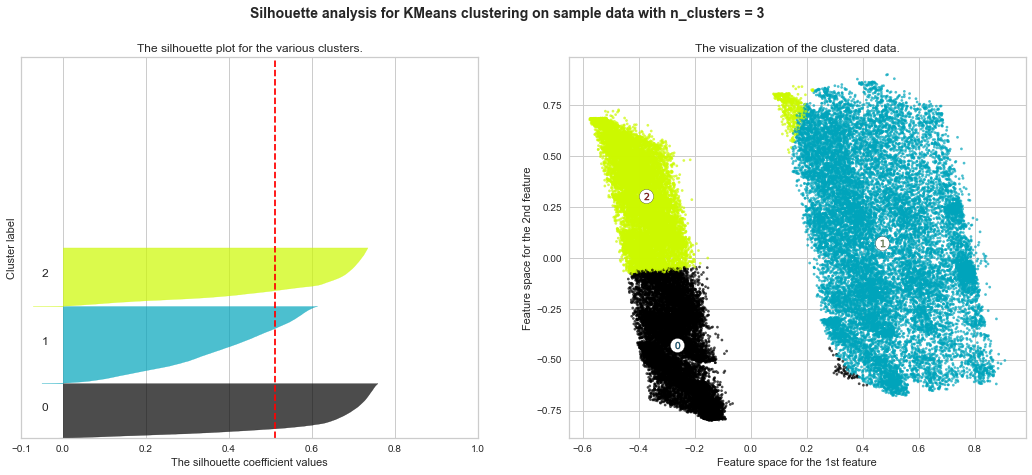

In [392]:
# QuantileTransformer(random_state=0)
# Create a subplot with 1 row and 2 columns
n_clusters = 3
n_components = 3
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (3 + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
reduced_data = PCA(n_components=2).fit_transform(X50perc_quantrans)
kmeans = KMeans(n_clusters=n_clusters)
# kmeans.fit(reduced_data)
estimator_QuantileTransformer = make_pipeline(QuantileTransformer(random_state=0), PCA(n_components=n_components), kmeans).fit(X_50perc_sample)
cluster_labels = kmeans.labels_

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(reduced_data, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = 3"),
             fontsize=14, fontweight='bold')

plt.show()

<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

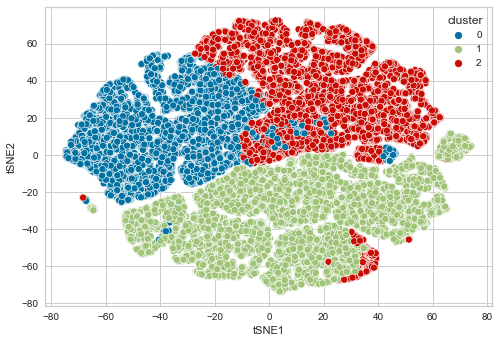

In [393]:
# affichage tSNE
# tsne_affichage = TSNE(n_components=2)
# QuantileTransformer(random_state=0)
X50perc_quantransf_tsne = pd.DataFrame(tsne_affichage.fit_transform(X50perc_quantrans),columns=['tSNE1','tSNE2'])
X50perc_quantransf_tsne['cluster'] = pd.Categorical(cluster_labels)
sns.scatterplot(x="tSNE1",y="tSNE2",hue="cluster",data=X50perc_quantransf_tsne)

In [394]:
X50perc_quantransf_clusted = X_50perc_sample.copy()

In [395]:
X50perc_quantransf_clusted['clusters_quantransf_kmeans']= pd.Categorical(cluster_labels)

<Figure size 576x396 with 0 Axes>

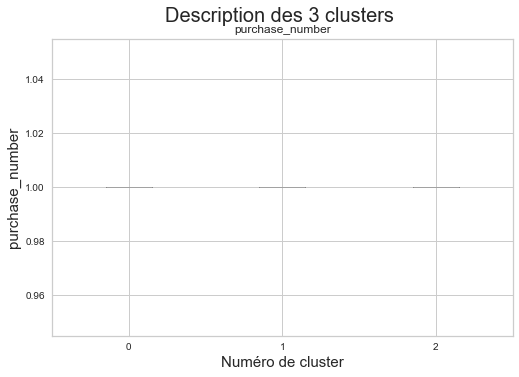

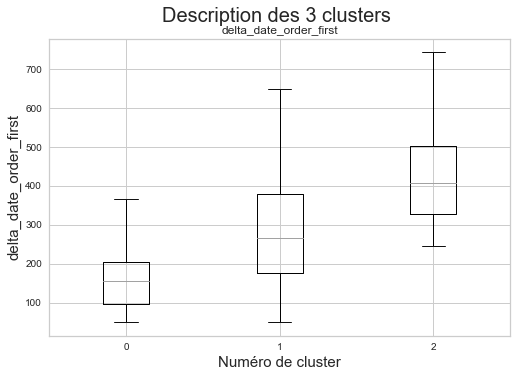

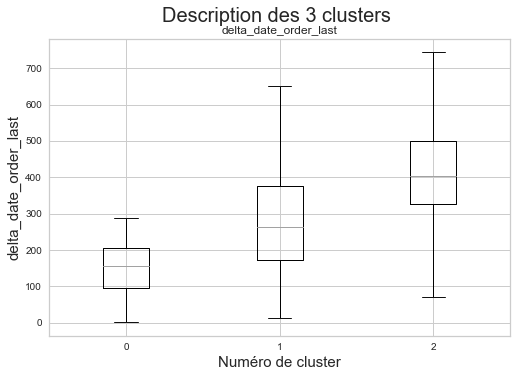

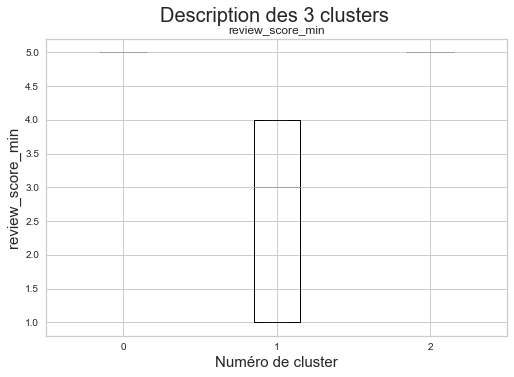

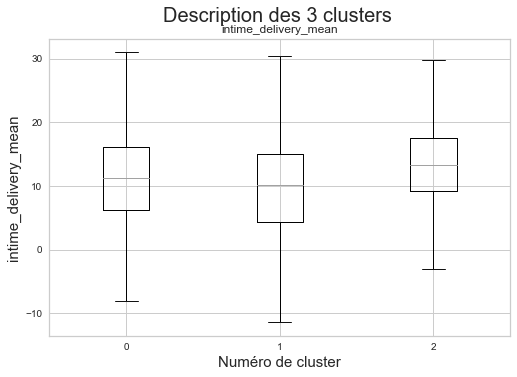

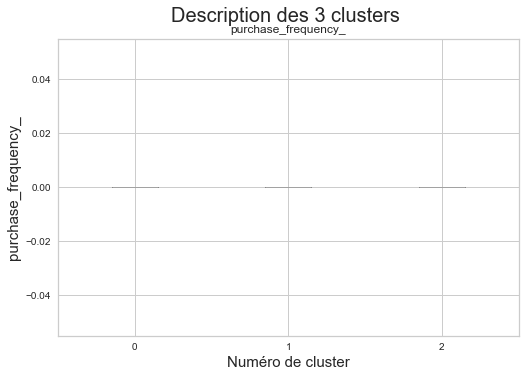

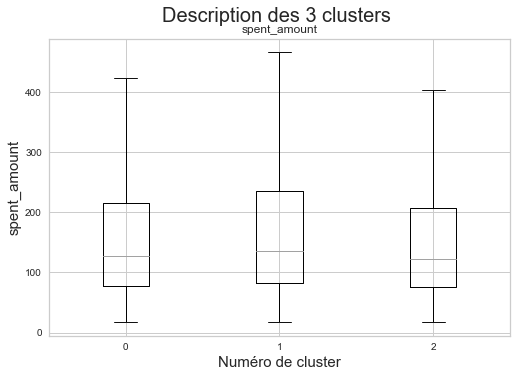

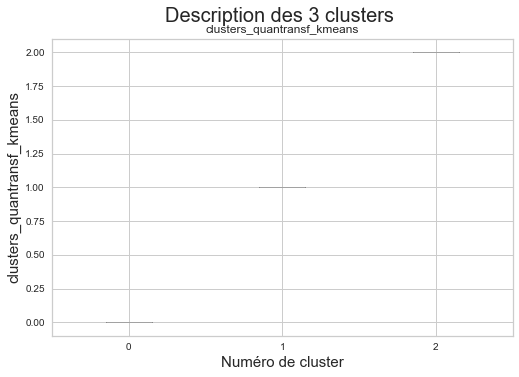

In [396]:
plt.figure()

for col in X50perc_quantransf_clusted.columns:
    X50perc_quantransf_clusted.boxplot(column=[col], by= X50perc_quantransf_clusted['clusters_quantransf_kmeans'], showfliers=False)
# plt.title('AAA')
    plt.suptitle(f'Description des {len(np.unique(cluster_labels))} clusters ', fontsize = 20) # 
    plt.xlabel('Numéro de cluster', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel(f'{col}', fontsize = 15) # y-axis label with fontsize 15
    plt.show()

In [397]:
X50perc_quantransf_tsne['cluster_name'] = np.where((X50perc_quantransf_tsne['cluster'] == 0),'nouveau_client', X50perc_quantransf_tsne['cluster'])

In [398]:
X50perc_quantransf_tsne['cluster_name'] = np.where((X50perc_quantransf_tsne['cluster'] == 1),'client_recent_mécontant', X50perc_quantransf_tsne['cluster_name'])

In [399]:
X50perc_quantransf_tsne['cluster_name'] = np.where((X50perc_quantransf_tsne['cluster'] == 2),'ancient_client', X50perc_quantransf_tsne['cluster_name'])

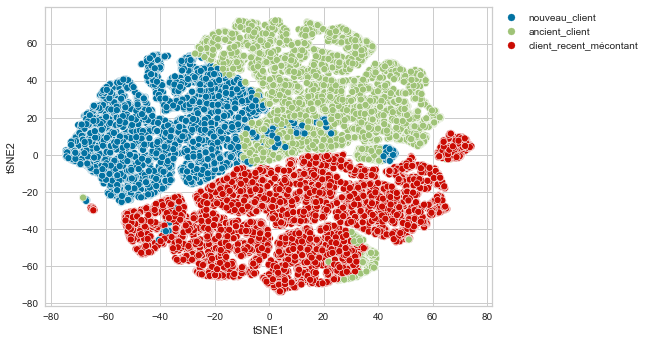

In [401]:
sns.scatterplot(x="tSNE1",y="tSNE2",hue="cluster_name",data=X50perc_quantransf_tsne)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.01), frameon=False)

For n_clusters = 4 The average silhouette_score is : 0.5532158035021276


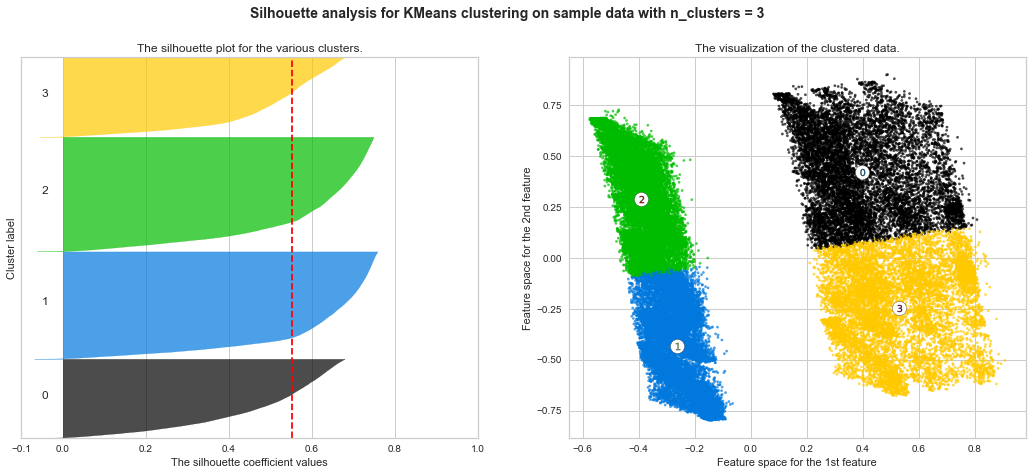

In [403]:
# QuantileTransformer(random_state=0)
# Create a subplot with 1 row and 2 columns
n_clusters = 4
n_components = 3
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X50perc_quantrans) + (3 + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
reduced_data = PCA(n_components=2).fit_transform(X50perc_quantrans)
kmeans = KMeans(n_clusters=n_clusters)
# kmeans.fit(reduced_data)
estimator_QuantileTransformer = make_pipeline(QuantileTransformer(random_state=0), PCA(n_components=n_components), kmeans).fit(X_50perc_sample)
cluster_labels = kmeans.labels_

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(reduced_data, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle((f"Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = {n_clusters}"),
             fontsize=14, fontweight='bold')

plt.show()

<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

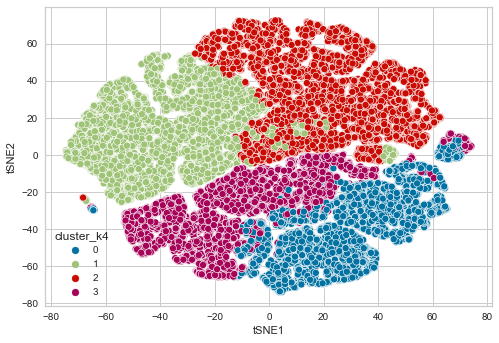

In [404]:
# affichage tSNE
# tsne_affichage = TSNE(n_components=2)
# QuantileTransformer(random_state=0)
# X50perc_quantransf_tsne = pd.DataFrame(tsne_affichage.fit_transform(X50perc_quantrans),columns=['tSNE1','tSNE2'])
X50perc_quantransf_tsne['cluster_k4'] = pd.Categorical(cluster_labels)
sns.scatterplot(x="tSNE1",y="tSNE2",hue="cluster_k4",data=X50perc_quantransf_tsne)

In [405]:
X50perc_quantransf_clusted['clusters_quantransf_k4']= pd.Categorical(cluster_labels)

<Figure size 576x396 with 0 Axes>

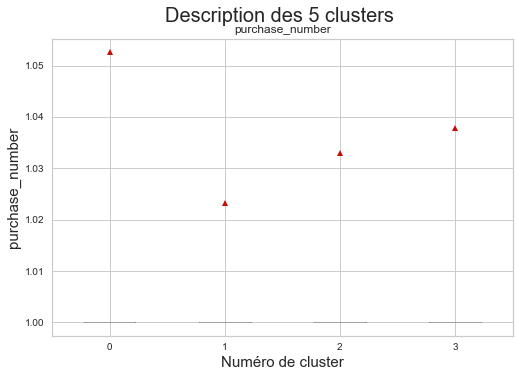

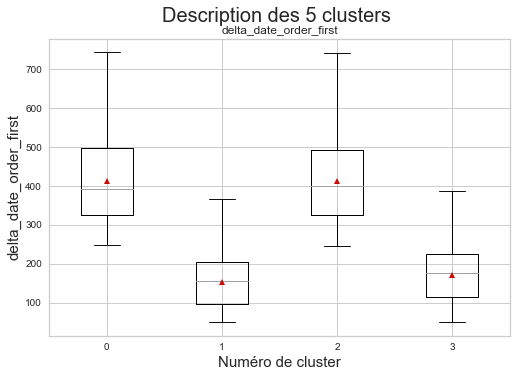

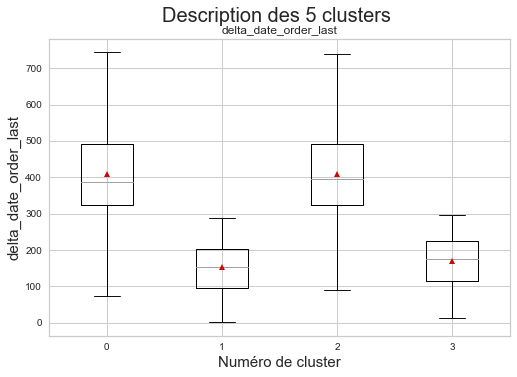

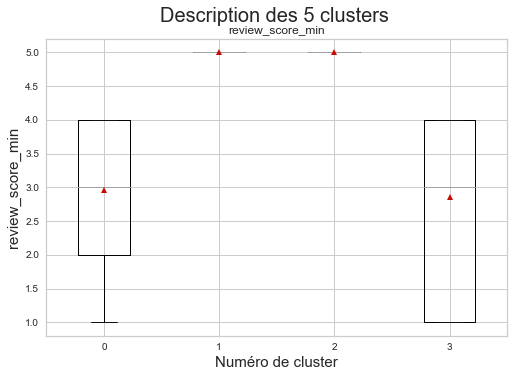

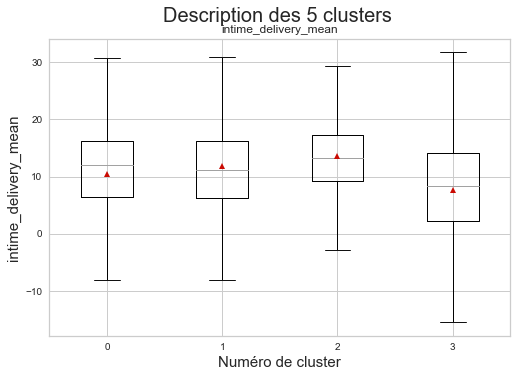

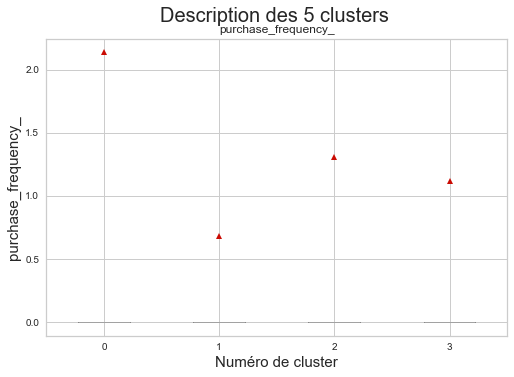

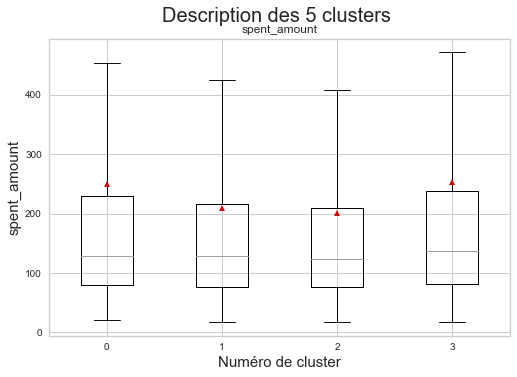

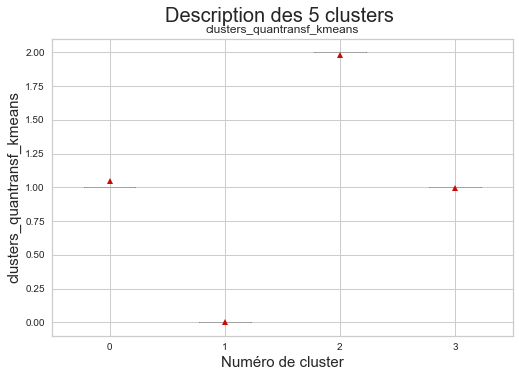

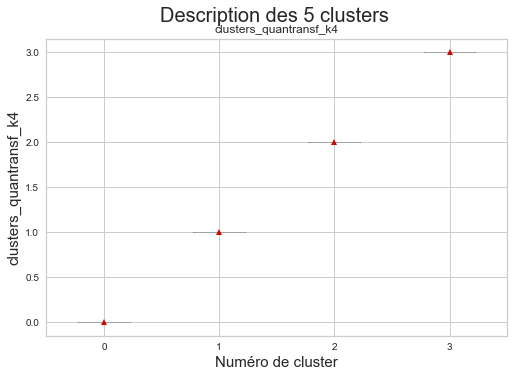

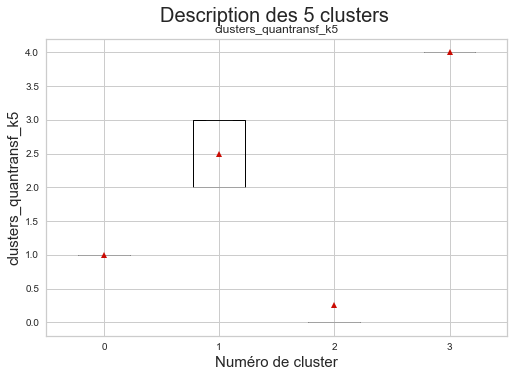

In [421]:
plt.figure()

for col in X50perc_quantransf_clusted.columns:
    X50perc_quantransf_clusted.boxplot(column=[col], by= X50perc_quantransf_clusted['clusters_quantransf_k4'],
                                       showfliers=False, showmeans=True)
# plt.title('AAA')
    plt.suptitle(f'Description des {len(np.unique(cluster_labels))} clusters ', fontsize = 20) # 
    plt.xlabel('Numéro de cluster', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel(f'{col}', fontsize = 15) # y-axis label with fontsize 15
    plt.show()

In [426]:
X50perc_grouped = X50perc_quantransf_clusted.groupby(['clusters_quantransf_k4'])

In [428]:
X50perc_grouped.mean()

purchase_number  delta_date_order_first  \
clusters_quantransf_k4                                            
0                              1.052583              413.663162   
1                              1.023153              153.179070   
2                              1.032990              412.761292   
3                              1.037835              170.850040   

                        delta_date_order_last  review_score_min  \
clusters_quantransf_k4                                            
0                                  409.170513          2.957851   
1                                  151.724650          5.000000   
2                                  410.005966          5.000000   
3                                  168.454103          2.859633   

                        intime_delivery_mean  purchase_frequency_  \
clusters_quantransf_k4                                              
0                                  10.434256             2.136284   
1                                  11.756781             0.684805   
2                                  13.501757             1.306815   
3                                   7.685607             1.114589   

                        spent_amount  
clusters_quantransf_k4                
0                         249.302826  
1                         208.830476  
2                         200.931252  
3                         252.916584

In [429]:
X50perc_grouped.median()

purchase_number  delta_date_order_first  \
clusters_quantransf_k4                                            
0                                     1              393.292627   
1                                     1              155.162303   
2                                     1              398.908762   
3                                     1              176.453854   

                        delta_date_order_last  review_score_min  \
clusters_quantransf_k4                                            
0                                  387.929334                 3   
1                                  154.250949                 5   
2                                  395.095590                 5   
3                                  174.386829                 3   

                        intime_delivery_mean  purchase_frequency_  \
clusters_quantransf_k4                                              
0                                  12.083883                  0.0   
1                                  11.170278                  0.0   
2                                  13.198588                  0.0   
3                                   8.359132                  0.0   

                        spent_amount  
clusters_quantransf_k4                
0                             129.17  
1                             128.34  
2                             123.70  
3                             136.76

In [430]:
# le symbole de Real brasilien est R$

In [408]:
X50perc_quantransf_tsne['cluster_name_k4'] = np.where((X50perc_quantransf_tsne['cluster_k4'] == 0),'ancient_client_mécontant', X50perc_quantransf_tsne['cluster_k4'])

In [409]:
X50perc_quantransf_tsne['cluster_name_k4'] = np.where((X50perc_quantransf_tsne['cluster_k4'] == 1),'nouveau_client_satisfait', X50perc_quantransf_tsne['cluster_name_k4'])

In [410]:
X50perc_quantransf_tsne['cluster_name_k4'] = np.where((X50perc_quantransf_tsne['cluster_k4'] == 2),'ancient_client_satisfait', X50perc_quantransf_tsne['cluster_name_k4'])

In [411]:
X50perc_quantransf_tsne['cluster_name_k4'] = np.where((X50perc_quantransf_tsne['cluster_k4'] == 3),'nouveau_client_mécontant', X50perc_quantransf_tsne['cluster_name_k4'])

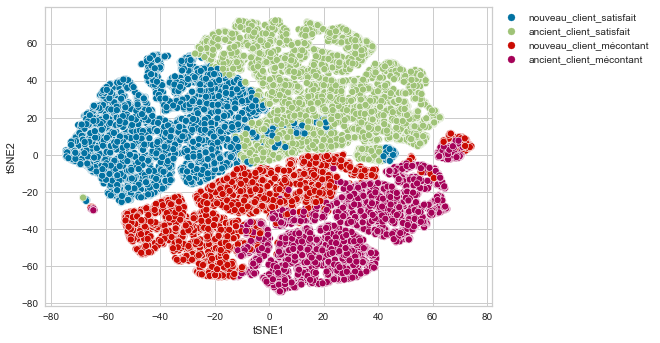

In [412]:
sns.scatterplot(x="tSNE1",y="tSNE2",hue="cluster_name_k4",data=X50perc_quantransf_tsne)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.01), frameon=False)

For n_clusters = 5 The average silhouette_score is : 0.36720986525433125


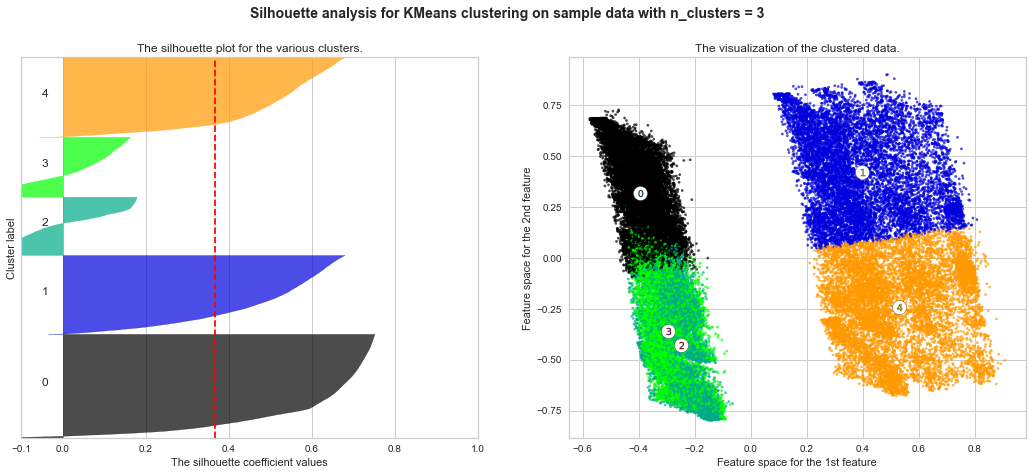

In [414]:
# QuantileTransformer(random_state=0)
# Create a subplot with 1 row and 2 columns
n_clusters = 5
n_components = 3
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X50perc_quantrans) + (3 + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
reduced_data = PCA(n_components=2).fit_transform(X50perc_quantrans)
kmeans = KMeans(n_clusters=n_clusters)
# kmeans.fit(reduced_data)
estimator_QuantileTransformer = make_pipeline(QuantileTransformer(random_state=0), PCA(n_components=n_components),
                                              kmeans).fit(X_50perc_sample)
cluster_labels = kmeans.labels_

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(reduced_data, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = 3"),
             fontsize=14, fontweight='bold')

plt.show()

<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

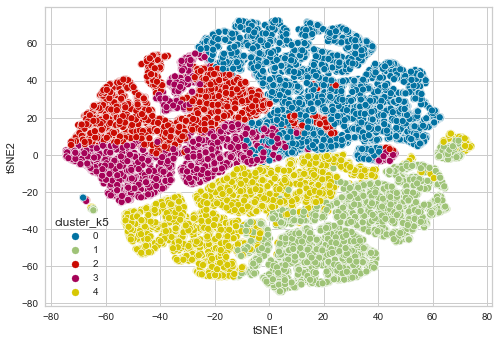

In [415]:
X50perc_quantransf_tsne['cluster_k5'] = pd.Categorical(cluster_labels)
sns.scatterplot(x="tSNE1",y="tSNE2",hue="cluster_k5",data=X50perc_quantransf_tsne)

In [416]:
X50perc_quantransf_clusted['clusters_quantransf_k5']= pd.Categorical(cluster_labels)

<Figure size 576x396 with 0 Axes>

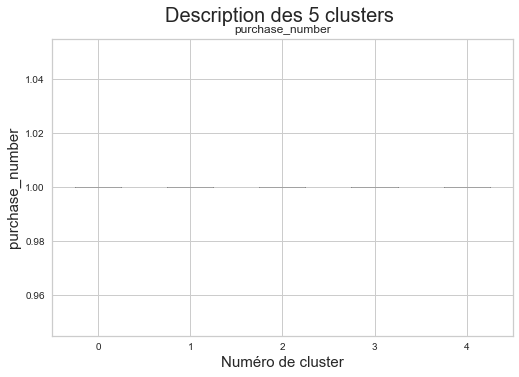

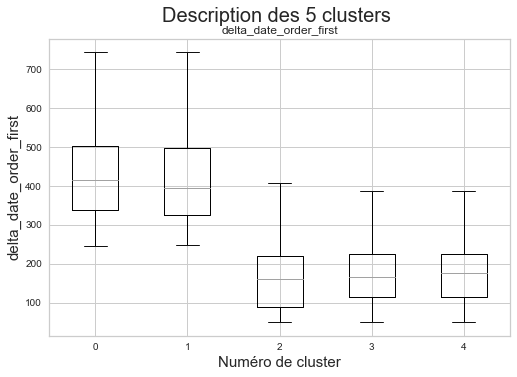

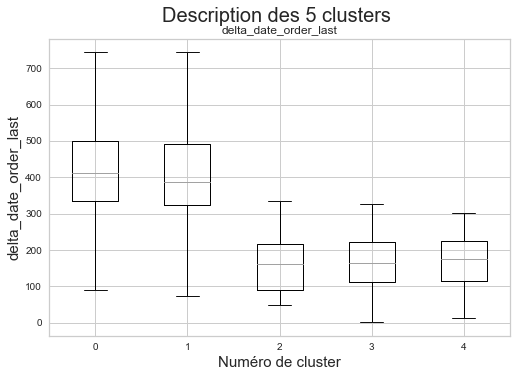

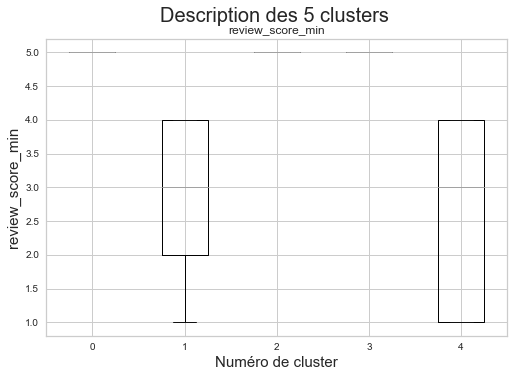

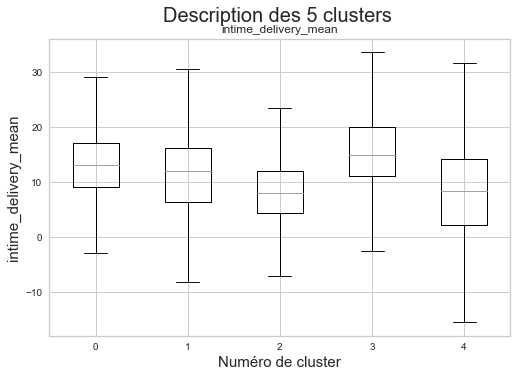

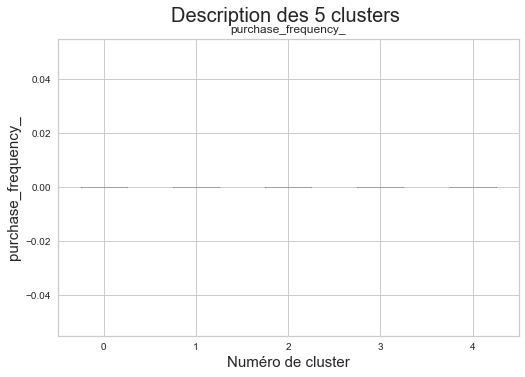

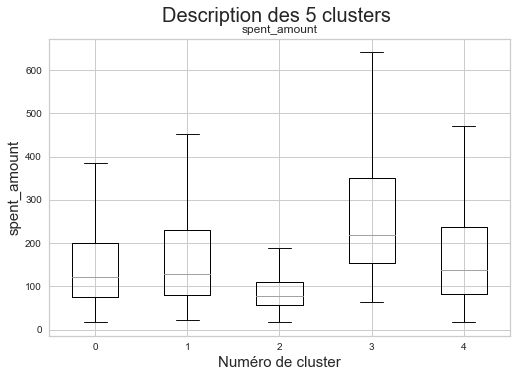

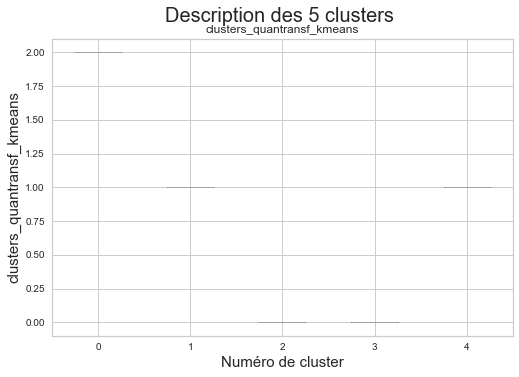

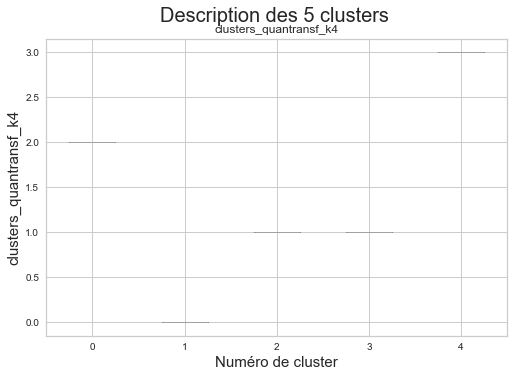

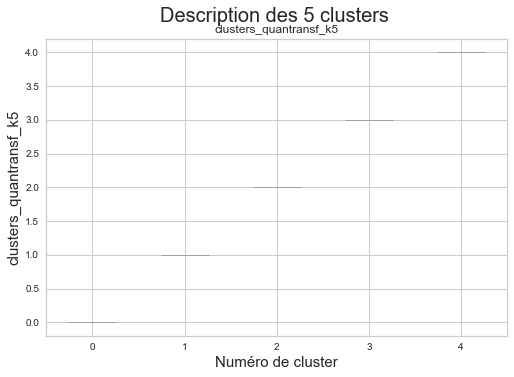

In [417]:
plt.figure()

for col in X50perc_quantransf_clusted.columns:
    X50perc_quantransf_clusted.boxplot(column=[col], by= X50perc_quantransf_clusted['clusters_quantransf_k5'], showfliers=False)
# plt.title('AAA')
    plt.suptitle(f'Description des {len(np.unique(cluster_labels))} clusters ', fontsize = 20) # 
    plt.xlabel('Numéro de cluster', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel(f'{col}', fontsize = 15) # y-axis label with fontsize 15
    plt.show()